# Data Processing

In [347]:
import os
import anndata as ad
import math
import scipy as sip
from scipy import sparse
import scanpy as scp
import pickle
import pandas as pd
import numpy as np
import igraph as ig
import seaborn as sb
import snf
import sklearn as skl
from sklearn import cluster
from snf import compute, metrics
import matplotlib.pyplot as plt
from PyComplexHeatmap import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [466]:
data = os.path.abspath(os.path.join(os.getcwd(),"../data"))

input = os.path.join(data, "input")
output = os.path.join(data, "output")

original = os.path.join(input, "original")
complementary = os.path.join(input, "complementary")

pb = os.path.join(output, "pb")
shared = os.path.join(output, "shared")
shared_74 = os.path.join(output, "shared_74")
fusion = os.path.join(output, "fusion")

## Loading Data

In [337]:
# Read Original Data
adt = ad.read_h5ad(os.path.join(original, "adt_pp.h5ad"))
bulkRNA = ad.read_h5ad(os.path.join(original, "bulkRNA_pp.h5ad"))
cytof = ad.read_h5ad (os.path.join(original, "cytof_pp.h5ad"))
facs = ad.read_h5ad(os.path.join(original, "facs_pp.h5ad"))
luminex = ad.read_h5ad(os.path.join(original, "luminex_pp.h5ad"))
scRNA = ad.read_h5ad(os.path.join(original, "scRNA_pp.h5ad"))

# Read complementary data
all_proteins = pd.read_csv(os.path.join(complementary, "all_proteins_V1.txt"), sep= "	")
COMBAT_CLINVAR_for_processed = pd.read_csv(os.path.join(complementary, "COMBAT_CLINVAR_for_processed.txt"), sep= "	")
module_information =  pd.read_excel(os.path.join(complementary, "module_names.xlsx"), sheet_name="meta_analysis_assignments")
with open(os.path.join(complementary, "id_to_name.pickle"), "rb") as f:
    id_to_name = pickle.load(f) 
with open(os.path.join(complementary, "name_to_id.pickle"), "rb") as f:
    name_to_id = pickle.load(f) 

# Module data for subsetting bulks 
bulk_genes_membership = pd.read_csv(os.path.join(complementary, "bulk_genes_membership.tsv"), sep= "\t")
membership_all_celltypes = pd.read_csv(os.path.join(complementary, "membership_all_celltypes.tsv"), sep= "\t")

# Label harmonization files
cite_cells = pd.read_csv(os.path.join(complementary, "cite_cells.csv"))
cytof_cells_harmonised = pd.read_csv(os.path.join(complementary, "cytof_cells_harmonised.csv"), sep=';')
cytof_cells = pd.read_csv(os.path.join(complementary, "cytof_cells.csv"))



/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/homebrew/Caskroom/miniforge/ba

## Preprocessing
Pseudobulks will aggregate patient information, so we need to transform observations from samples to patient names

In [353]:
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

In [101]:
shared_patients = list(set(adt.obs.COMBAT_ID).intersection(set(cytof.obs.COMBAT_ID)).intersection(set(scRNA.obs.COMBAT_ID)).intersection(set(bulkRNA.obs.COMBAT_ID)).intersection(set(facs.obs.COMBAT_ID)).intersection(set(luminex.obs.COMBAT_ID)))
shared_patients.sort()

In [102]:
# ADT
adt.obs_names = [str(i) for i in range(len(adt.obs_names)) ]
indices = []
for p in shared_patients:
    indices += list(adt.obs_names[adt.obs.COMBAT_ID == p])

adt_shared = adt[indices]

# BulkRNA
bulkRNA.obs_names = [str(i) for i in range(len(bulkRNA.obs_names)) ]
indices = []
for p in shared_patients:
    indices += list(bulkRNA.obs_names[bulkRNA.obs.COMBAT_ID == p])
    
bulkRNA_shared = bulkRNA[indices]

# CiteRNA
scRNA.obs_names = [str(i) for i in range(len(scRNA.obs_names)) ]
indices = []
for p in shared_patients:
    indices += list(scRNA.obs_names[scRNA.obs.COMBAT_ID == p])
    
scRNA_shared = scRNA[indices]

# CyTOF
cytof.obs_names = [str(i) for i in range(len(cytof.obs_names)) ]
indices = []
for p in shared_patients:
    indices += list(cytof.obs_names[cytof.obs.COMBAT_ID == p])
    
cytof_shared = cytof[indices]

# Luminex
luminex.obs_names = [str(i) for i in range(len(luminex.obs_names)) ]
indices = []
for p in shared_patients:
    indices += list(luminex.obs_names[luminex.obs.COMBAT_ID == p])
    
luminex_shared = luminex[indices]

# FACS
facs.obs_names = [str(i) for i in range(len(facs.obs_names)) ]
indices = []
for p in shared_patients:
    indices += list(facs.obs_names[facs.obs.COMBAT_ID == p])
    
facs_shared = facs[indices]

In [103]:
adt.obs_names = adt.obs.COMBAT_ID.copy()
bulkRNA.obs_names = bulkRNA.obs.COMBAT_ID.copy()
cytof.obs_names = cytof.obs.COMBAT_ID.copy()
facs.obs_names = facs.obs.COMBAT_ID.copy()
luminex.obs_names = luminex.obs.COMBAT_ID.copy()
scRNA.obs_names =  scRNA.obs.COMBAT_ID.copy()

/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/anndata/_core/anndata.py:856: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['S00109', 'S00112', 'G05153', 'S00005', 'S00061']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "obs")
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/anndata/_core/anndata.py:856: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['S00016', 'S00020', 'S00024', 'S00027', 'S00028']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "obs")
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/anndata/_core/anndata.py:856: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['H00067', 'H00067', 'H00067', 'H00067', 'H00067']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "obs")
/opt/homebrew/Caskroom/minif

In [104]:
adt_shared.obs_names = adt_shared.obs.COMBAT_ID.copy()
bulkRNA_shared.obs_names = bulkRNA_shared.obs.COMBAT_ID.copy()
cytof_shared.obs_names = cytof_shared.obs.COMBAT_ID.copy()
facs_shared.obs_names = facs_shared.obs.COMBAT_ID.copy()
luminex_shared.obs_names = luminex_shared.obs.COMBAT_ID.copy()
scRNA_shared.obs_names =  scRNA_shared.obs.COMBAT_ID.copy()

/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/anndata/_core/anndata.py:856: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['G05073', 'G05073', 'G05073', 'G05073', 'G05073']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "obs")
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/anndata/_core/anndata.py:856: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['G05073', 'H00053', 'H00054', 'H00058', 'H00064']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "obs")
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [349]:
module_names = list(module_information.name.unique())

# For every module, extract what graphs they correspond to 
id_to_module_name = {}
module_name_to_id = {n: [] for n in names} 

for process_name in module_names:
    data_subset = module_information[module_information.name == process_name]
    for i in data_subset.index:
        data_item = data_subset.loc[i]
        module = data_item.module.split(",")
        if len(module) == 1:
            name = "citeRNA_" + data_item.cell_type + "-" + module[0].lower()
            id = name_to_id[name]
            module_name_to_id[process_name].append(id)
            id_to_module_name[id] = process_name
        else:
            for m in module:
                name = "citeRNA_" + data_item.cell_type + "-" + m.lower()
                id = name_to_id[name]
                module_name_to_id[process_name].append(id)
                id_to_module_name[id] = process_name

module_name_to_id

{'IFN': ['G77', 'G151', 'G54', 'G48', 'G101', 'G112', 'G17'],
 'AP1': ['G39', 'G114', 'G18', 'G92', 'G50', 'G65', 'G79'],
 'cycling': ['G96', 'G38', 'G19', 'G123', 'G80', 'G148'],
 'C19': ['G56', 'G73', 'G12', 'G122', 'G105'],
 'ZNF': ['G55', 'G110', 'G91', 'G72', 'G15', 'G45']}

## Generating PB

In [7]:
rna_cite_pseudobulks = {}

for i, patient in enumerate(pd.unique(scRNA.obs_names)): # Go through every patient
        rna_cite_patient = scRNA[scRNA.obs.COMBAT_ID == patient,:] # Filter out all the rows/ measurements that have the ID COMBAT_ID
        for cell_type in pd.unique(scRNA.obs.Annotation_major_subset): # Go through every cell type 
            rna_cite_patient_cell_type = rna_cite_patient[rna_cite_patient.obs.Annotation_major_subset == cell_type, :] # From all the patients with PID, filter out those measurements that are related to a specific cell type
            if len(rna_cite_patient_cell_type) > 0:
                for module in pd.unique(membership_all_celltypes.module): # Go through every module 
                    gene_membership_cite_module = membership_all_celltypes.loc[membership_all_celltypes.module == module, 'gene_name'] # slice based on labels, and map module name to gene name 
                    print(i, patient, cell_type, module)
                    
                    genes = list(set(gene_membership_cite_module).intersection(set(rna_cite_patient_cell_type.var_names))) # To make sure the genes are column names 
                    rna_cite_patient_cell_type_module = rna_cite_patient_cell_type[:, genes] # Between the measurements that are for a specific patient and cell type, filter out specific genes that belong to the same module
                   
                    if rna_cite_patient_cell_type_module.shape[0] == 0:
                        raise ValueError("no observations for the current sum")
         
                    if np.isnan(rna_cite_patient_cell_type_module.layers['raw'].data).any():
                        raise ValueError("row contains nan care!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
                    
                    row = rna_cite_patient_cell_type_module.X.toarray()             # use normalized counts of the selected gene columns belonging to a specific module
                                                                                    # of the selected patient with PID 
                                                                                    # of the selected cell types
                    if row.shape[0] > 1:
                        row = row.mean(axis=0) # If multiple such data exist, average them 
                    else:
                        row = row[0]

                    if np.any(np.isnan(row)):
                        raise ValueError("row contains nan care!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
                    key = f'{cell_type}-{module}'
                    if key not in rna_cite_pseudobulks:
                        df = pd.DataFrame(columns=genes)
                        df.loc[patient] = row
                        rna_cite_pseudobulks[key] = df
                    else:
                        rna_cite_pseudobulks[key].loc[patient] = row
                    

0 S00109 NK greenyellow
0 S00109 NK tan
0 S00109 NK red
0 S00109 NK turquoise
0 S00109 NK green
0 S00109 NK purple
0 S00109 NK brown
0 S00109 NK blue
0 S00109 NK black
0 S00109 NK salmon
0 S00109 NK lightcyan
0 S00109 NK grey60
0 S00109 NK grey
0 S00109 NK lightgreen
0 S00109 NK pink
0 S00109 NK yellow
0 S00109 NK magenta
0 S00109 NK cyan
0 S00109 NK midnightblue
0 S00109 NK lightyellow
0 S00109 CD8 greenyellow
0 S00109 CD8 tan
0 S00109 CD8 red
0 S00109 CD8 turquoise
0 S00109 CD8 green
0 S00109 CD8 purple
0 S00109 CD8 brown
0 S00109 CD8 blue
0 S00109 CD8 black
0 S00109 CD8 salmon
0 S00109 CD8 lightcyan
0 S00109 CD8 grey60
0 S00109 CD8 grey
0 S00109 CD8 lightgreen
0 S00109 CD8 pink
0 S00109 CD8 yellow
0 S00109 CD8 magenta
0 S00109 CD8 cyan
0 S00109 CD8 midnightblue
0 S00109 CD8 lightyellow
0 S00109 nan greenyellow
0 S00109 nan tan
0 S00109 nan red
0 S00109 nan turquoise
0 S00109 nan green
0 S00109 nan purple
0 S00109 nan brown
0 S00109 nan blue
0 S00109 nan black
0 S00109 nan salmon
0 S

KeyboardInterrupt: 

In [ ]:
adt_cite_pseudobulks = {}
for i, patient in enumerate(pd.unique(adt.obs_names)):
    adt_cite_patient = adt[adt.obs.COMBAT_ID == patient, :]
    for cell_type in pd.unique(adt.obs.Annotation_major_subset):
        adt_cite_patient_cell_type = adt_cite_patient[adt_cite_patient.obs.Annotation_major_subset == cell_type, :]
        if len(adt_cite_patient_cell_type) > 0:
            print(i, patient, cell_type)
            key = f'{cell_type}'
            row = adt_cite_patient_cell_type.X.toarray()
            if row.shape[0] > 1:
                row = row.mean(axis=0)
            else:
                row = row[0]
            if key not in adt_cite_pseudobulks:
                df = pd.DataFrame(columns = adt.var_names)
                df.loc[patient] = row
                adt_cite_pseudobulks[key] = df
            else:
                adt_cite_pseudobulks[key].loc[patient] = row

0 S00109 NK
0 S00109 CD8
0 S00109 nan
0 S00109 ncMono
0 S00109 cMono
0 S00109 CD4
0 S00109 B
0 S00109 MAIT
0 S00109 PB
0 S00109 iNKT
0 S00109 DN
0 S00109 DP
0 S00109 GDT
0 S00109 HSC
0 S00109 DC
0 S00109 PLT
0 S00109 RET
1 S00112 NK
1 S00112 CD8
1 S00112 nan
1 S00112 ncMono
1 S00112 cMono
1 S00112 CD4
1 S00112 B
1 S00112 MAIT
1 S00112 PB
1 S00112 iNKT
1 S00112 DN
1 S00112 DP
1 S00112 GDT
1 S00112 HSC
1 S00112 DC
1 S00112 PLT
2 G05153 NK
2 G05153 CD8
2 G05153 nan
2 G05153 ncMono
2 G05153 cMono
2 G05153 CD4
2 G05153 B
2 G05153 MAIT
2 G05153 PB
2 G05153 iNKT
2 G05153 DN
2 G05153 DP
2 G05153 GDT
2 G05153 HSC
2 G05153 DC
3 S00005 NK
3 S00005 CD8
3 S00005 nan
3 S00005 ncMono
3 S00005 cMono
3 S00005 CD4
3 S00005 B
3 S00005 MAIT
3 S00005 PB
3 S00005 iNKT
3 S00005 DN
3 S00005 DP
3 S00005 GDT
3 S00005 HSC
3 S00005 DC
3 S00005 PLT
3 S00005 RET
4 S00061 NK
4 S00061 CD8
4 S00061 nan
4 S00061 ncMono
4 S00061 cMono
4 S00061 CD4
4 S00061 B
4 S00061 MAIT
4 S00061 PB
4 S00061 iNKT
4 S00061 DN
4 S00061 D

In [ ]:
cytof_pseudobulks = {}
for i, patient in enumerate(pd.unique(cytof.obs_names)):
    cytof_patient = cytof[cytof.obs.COMBAT_ID == patient, :]
    for cell_type in pd.unique(cytof.obs.Annotation_major_subset):
        cytof_patient_cell_type = cytof_patient[cytof_patient.obs.Annotation_major_subset == cell_type, :]
        if len(cytof_patient_cell_type) > 0:
            print(i, patient, cell_type)
            key = f'{cell_type}'
            row = cytof_patient_cell_type.X.toarray()
            if row.shape[0] > 1:
                row = row.mean(axis=0)
            else:
                row = row[0]
            if key not in cytof_pseudobulks:
                df = pd.DataFrame(columns=cytof.var_names)
                df.loc[patient] = row
                cytof_pseudobulks[key] = df
            else:
                cytof_pseudobulks[key].loc[patient] = row

            print(i, patient, cell_type)

0 H00067 CD8
0 H00067 CD8
0 H00067 B
0 H00067 B
0 H00067 cMono
0 H00067 cMono
0 H00067 CD4
0 H00067 CD4
0 H00067 GDT
0 H00067 GDT
0 H00067 DC
0 H00067 DC
0 H00067 Basophil
0 H00067 Basophil
0 H00067 NK
0 H00067 NK
0 H00067 ncMono
0 H00067 ncMono
0 H00067 MAIT
0 H00067 MAIT
0 H00067 DN
0 H00067 DN
0 H00067 PB
0 H00067 PB
0 H00067 nan
0 H00067 nan
1 N00023 CD8
1 N00023 CD8
1 N00023 B
1 N00023 B
1 N00023 cMono
1 N00023 cMono
1 N00023 CD4
1 N00023 CD4
1 N00023 GDT
1 N00023 GDT
1 N00023 DC
1 N00023 DC
1 N00023 Basophil
1 N00023 Basophil
1 N00023 NK
1 N00023 NK
1 N00023 ncMono
1 N00023 ncMono
1 N00023 MAIT
1 N00023 MAIT
1 N00023 DN
1 N00023 DN
1 N00023 PB
1 N00023 PB
1 N00023 nan
1 N00023 nan
2 S00028 CD8
2 S00028 CD8
2 S00028 B
2 S00028 B
2 S00028 cMono
2 S00028 cMono
2 S00028 CD4
2 S00028 CD4
2 S00028 GDT
2 S00028 GDT
2 S00028 DC
2 S00028 DC
2 S00028 Basophil
2 S00028 Basophil
2 S00028 NK
2 S00028 NK
2 S00028 ncMono
2 S00028 ncMono
2 S00028 MAIT
2 S00028 MAIT
2 S00028 DN
2 S00028 DN
2 S000

In [ ]:
rna_bulk_pseudobulks = {}
for i, patient in enumerate(pd.unique(bulkRNA.obs_names)):
    rna_bulk_patient = bulkRNA[bulkRNA.obs.COMBAT_ID == patient, :]
    for module in pd.unique(bulk_genes_membership.module):
        print(i, patient, module)
        gene_membership_bulk_module = bulk_genes_membership.loc[bulk_genes_membership.module == module, 'gene_name']
        rna_bulk_patient_module = rna_bulk_patient[:, gene_membership_bulk_module.index]
        key = f'{module}'
        row = rna_bulk_patient_module.X.toarray()
        if row.shape[0] > 1:
            row = row.mean(axis=0)
        else:
            row = row[0]
        if key not in rna_bulk_pseudobulks:
            df = pd.DataFrame(index = pd.unique(bulkRNA.obs.PID), columns = gene_membership_bulk_module)
            df.iloc[i] = row
            rna_bulk_pseudobulks[key] = df
        else:
            rna_bulk_pseudobulks[key].iloc[i] = row

0 S00016 greenyellow
0 S00016 green
0 S00016 magenta
0 S00016 lightgreen
0 S00016 black
0 S00016 turquoise
0 S00016 lightcyan
0 S00016 midnightblue
0 S00016 blue
0 S00016 grey60
0 S00016 purple
0 S00016 cyan
0 S00016 grey
1 S00020 greenyellow
1 S00020 green
1 S00020 magenta
1 S00020 lightgreen
1 S00020 black
1 S00020 turquoise
1 S00020 lightcyan
1 S00020 midnightblue
1 S00020 blue
1 S00020 grey60
1 S00020 purple
1 S00020 cyan
1 S00020 grey
2 S00024 greenyellow
2 S00024 green
2 S00024 magenta
2 S00024 lightgreen
2 S00024 black
2 S00024 turquoise
2 S00024 lightcyan
2 S00024 midnightblue
2 S00024 blue
2 S00024 grey60
2 S00024 purple
2 S00024 cyan
2 S00024 grey
3 S00027 greenyellow
3 S00027 green
3 S00027 magenta
3 S00027 lightgreen
3 S00027 black
3 S00027 turquoise
3 S00027 lightcyan
3 S00027 midnightblue
3 S00027 blue
3 S00027 grey60
3 S00027 purple
3 S00027 cyan
3 S00027 grey
4 S00028 greenyellow
4 S00028 green
4 S00028 magenta
4 S00028 lightgreen
4 S00028 black
4 S00028 turquoise
4 S00

In [ ]:
luminex_pseudobulks = pd.DataFrame(columns = luminex.var_names)
luminex_matrix = np.empty((0, len(luminex.var_names)))
for i, patient in enumerate(pd.unique(luminex.obs_names)):
    print(f"{i} {patient}")
    luminex_patient = luminex[luminex.obs.COMBAT_ID==patient, :]
    row = luminex_patient.X.toarray()
    if row.shape[0] > 1:
        row = row.mean(axis=0)
    else:
        row = row[0]
    
    luminex_pseudobulks.loc[patient] = row

0 S00029
1 S00052
2 S00109
3 S00099
4 S00094
5 S00027
6 S00147
7 S00124
8 S00030
9 S00065
10 S00054
11 S00007
12 S00111
13 S00024
14 S00043
15 S00055
16 S00095
17 S00143
18 S00040
19 S00020
20 S00008
21 S00068
22 S00005
23 S00050
24 S00073
25 S00079
26 S00064
27 S00037
28 S00148
29 S00074
30 S00069
31 S00053
32 S00067
33 S00061
34 S00033
35 S00081
36 S00091
37 S00038
38 S00048
39 S00041
40 S00045
41 S00127
42 S00009
43 S00087
44 S00118
45 S00084
46 S00100
47 S00042
48 S00060
49 S00134
50 S00119
51 S00096
52 S00057
53 S00097
54 S00078
55 S00028
56 S00145
57 S00080
58 S00141
59 S00072
60 S00077
61 S00056
62 S00136
63 S00066
64 S00039
65 S00034
66 S00085
67 S00018
68 S00036
69 S00106
70 S00003
71 S00076
72 S00129
73 S00133
74 S00112
75 S00138
76 S00046
77 S00110
78 S00113
79 S00058
80 S00022
81 S00075
82 S00063
83 S00137
84 S00006
85 S00031
86 S00049
87 S00059
88 S00002
89 S00104
90 S00139
91 S00115
92 S00062
93 S00016
94 S00114
95 S00131
96 S00142
97 S00082
98 G05098
99 G05065
100 G05234

In [ ]:
facs_pseudobulks = pd.DataFrame(columns = facs.var_names)
facs_matrix = np.empty((0, len(facs.var_names)))
for i, patient in enumerate(pd.unique(facs.obs_names)):
    print(f"{i} {patient}")
    facs_patient = facs[facs.obs.COMBAT_ID==patient, :]
    row = facs_patient.X.toarray()
    if row.shape[0] > 1:
        row = row.mean(axis=0)
    else:
        row = row[0]
    
    facs_pseudobulks.loc[patient] = row


0 S00078
1 S00040
2 G05097
3 S00104
4 S00027
5 N00024
6 S00034
7 G05164
8 S00119
9 S00033
10 H00054
11 S00056
12 G05092
13 S00016
14 H00085
15 S00020
16 N00032
17 G05061
18 S00058
19 S00052
20 S00039
21 U00607
22 S00045
23 S00068
24 S00005
25 S00041
26 S00006
27 N00029
28 U00701
29 N00021
30 S00048
31 S00007
32 G05078
33 N00033
34 H00049
35 S00097
36 G05171
37 N00039
38 S00042
39 S00064
40 N00047
41 U00605
42 S00095
43 S00037
44 S00003
45 H00058
46 S00113
47 S00129
48 N00006
49 G05077
50 S00148
51 N00012
52 U00619
53 N00049
54 S00134
55 S00094
56 S00060
57 H00072
58 S00109
59 S00024
60 S00067
61 N00007
62 H00052
63 N00025
64 N00050
65 S00106
66 S00049
67 U00503
68 N00017
69 S00126
70 S00099
71 H00070
72 N00023
73 N00028
74 S00142
75 S00054
76 S00069
77 G05105
78 S00114
79 U00617
80 S00053
81 N00013
82 G05073
83 H00053
84 U00601
85 S00030
86 U00504
87 S00081
88 S00124
89 S00082
90 G05112
91 S00002
92 H00064
93 N00037
94 U00501
95 N00038
96 S00076
97 S00065
98 S00072
99 U00502


In [ ]:
with open(os.path.join(pb,'citeRNA_pseudobulks.pickle'), 'wb') as f:
    pickle.dump(rna_cite_pseudobulks, f)

with open(os.path.join(pb,'adt_pseudobulks.pickle'), 'wb') as f:
    pickle.dump(adt_cite_pseudobulks, f)

with open(os.path.join(pb, 'cytof_pseudobulks.pickle'), 'wb') as f:
    pickle.dump(cytof_pseudobulks, f)

with open(os.path.join(pb, 'bulkRNA_pseudobulks.pickle'), 'wb') as f:
    pickle.dump(rna_bulk_pseudobulks, f)

luminex_pseudobulks.to_csv(os.path.join(pb, "luminex_pseudobulks.csv"))
facs_pseudobulks.to_csv(os.path.join(pb, "facs_pseudobulks.csv"))

## 75 Shared Patients Across Modalities PB

In [106]:
rna_cite_pseudobulks_shared_p = {}

for i, patient in enumerate(pd.unique(scRNA_shared.obs_names)): # Go through every patient
        rna_cite_patient = scRNA_shared[scRNA_shared.obs.COMBAT_ID == patient,:] # Filter out all the rows/ measurements that have the ID COMBAT_ID
        for cell_type in pd.unique(scRNA_shared.obs.Annotation_major_subset): # Go through every cell type 
            rna_cite_patient_cell_type = rna_cite_patient[rna_cite_patient.obs.Annotation_major_subset == cell_type, :] # From all the patients with PID, filter out those measurements that are related to a specific cell type
            if len(rna_cite_patient_cell_type) > 0:
                for module in pd.unique(membership_all_celltypes.module): # Go through every module 
                    gene_membership_cite_module = membership_all_celltypes.loc[membership_all_celltypes.module == module, 'gene_name'] # slice based on labels, and map module name to gene name 
                    print(i, patient, cell_type, module)
                    
                    genes = list(set(gene_membership_cite_module).intersection(set(rna_cite_patient_cell_type.var_names))) # To make sure the genes are column names 
                    rna_cite_patient_cell_type_module = rna_cite_patient_cell_type[:, genes] # Between the measurements that are for a specific patient and cell type, filter out specific genes that belong to the same module
                   
                    if rna_cite_patient_cell_type_module.shape[0] == 0:
                        raise ValueError("no observations for the current sum")
         
                    if np.isnan(rna_cite_patient_cell_type_module.layers['raw'].data).any():
                        raise ValueError("row contains nan care!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
                    
                    row = rna_cite_patient_cell_type_module.X.toarray()             # use normalized counts of the selected gene columns belonging to a specific module
                                                                                    # of the selected patient with PID 
                                                                                    # of the selected cell types
                    if row.shape[0] > 1:
                        row = row.mean(axis=0, dtype = "float64") # If multiple such data exist, average them 
                    else:
                        row = row[0]

                    if np.any(np.isnan(row)):
                        raise ValueError("row contains nan care!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
                    key = f'{cell_type}-{module}'
                    if key not in rna_cite_pseudobulks_shared_p:
                        df = pd.DataFrame(columns=genes, dtype = "float64")
                        df.loc[patient] = row
                        rna_cite_pseudobulks_shared_p[key] = df
                    else:
                        rna_cite_pseudobulks_shared_p[key].loc[patient] = row
                    

0 G05073 GDT greenyellow
0 G05073 GDT tan
0 G05073 GDT red
0 G05073 GDT turquoise
0 G05073 GDT green
0 G05073 GDT purple
0 G05073 GDT brown
0 G05073 GDT blue
0 G05073 GDT black
0 G05073 GDT salmon
0 G05073 GDT lightcyan
0 G05073 GDT grey60
0 G05073 GDT grey
0 G05073 GDT lightgreen
0 G05073 GDT pink
0 G05073 GDT yellow
0 G05073 GDT magenta
0 G05073 GDT cyan
0 G05073 GDT midnightblue
0 G05073 GDT lightyellow
0 G05073 CD4 greenyellow
0 G05073 CD4 tan
0 G05073 CD4 red
0 G05073 CD4 turquoise
0 G05073 CD4 green
0 G05073 CD4 purple
0 G05073 CD4 brown
0 G05073 CD4 blue
0 G05073 CD4 black
0 G05073 CD4 salmon
0 G05073 CD4 lightcyan
0 G05073 CD4 grey60
0 G05073 CD4 grey
0 G05073 CD4 lightgreen
0 G05073 CD4 pink
0 G05073 CD4 yellow
0 G05073 CD4 magenta
0 G05073 CD4 cyan
0 G05073 CD4 midnightblue
0 G05073 CD4 lightyellow
0 G05073 nan greenyellow
0 G05073 nan tan
0 G05073 nan red
0 G05073 nan turquoise
0 G05073 nan green
0 G05073 nan purple
0 G05073 nan brown
0 G05073 nan blue
0 G05073 nan black
0 G

In [107]:
adt_cite_pseudobulks_shared_p = {}
for i, patient in enumerate(pd.unique(adt_shared.obs_names)):
    adt_cite_patient = adt_shared[adt_shared.obs.COMBAT_ID == patient, :]
    for cell_type in pd.unique(adt_shared.obs.Annotation_major_subset):
        adt_cite_patient_cell_type = adt_cite_patient[adt_cite_patient.obs.Annotation_major_subset == cell_type, :]
        if len(adt_cite_patient_cell_type) > 0:
            print(i, patient, cell_type)
            key = f'{cell_type}'
            row = adt_cite_patient_cell_type.X.toarray()
            if row.shape[0] > 1:
                row = row.mean(axis=0, dtype = "float64")
            else:
                row = row[0]
            if key not in adt_cite_pseudobulks_shared_p:
                df = pd.DataFrame(columns = adt_shared.var_names, dtype = "float64")
                df.loc[patient] = row
                adt_cite_pseudobulks_shared_p[key] = df
            else:
                adt_cite_pseudobulks_shared_p[key].loc[patient] = row

0 G05073 GDT
0 G05073 CD4
0 G05073 nan
0 G05073 NK
0 G05073 CD8
0 G05073 cMono
0 G05073 B
0 G05073 DC
0 G05073 MAIT
0 G05073 ncMono
0 G05073 DP
0 G05073 DN
0 G05073 PB
0 G05073 iNKT
0 G05073 PLT
0 G05073 HSC
0 G05073 Mast
1 H00053 GDT
1 H00053 CD4
1 H00053 nan
1 H00053 NK
1 H00053 CD8
1 H00053 cMono
1 H00053 B
1 H00053 DC
1 H00053 MAIT
1 H00053 ncMono
1 H00053 DP
1 H00053 DN
1 H00053 PB
1 H00053 iNKT
1 H00053 PLT
1 H00053 HSC
1 H00053 Mast
2 H00054 GDT
2 H00054 CD4
2 H00054 nan
2 H00054 NK
2 H00054 CD8
2 H00054 cMono
2 H00054 B
2 H00054 DC
2 H00054 MAIT
2 H00054 ncMono
2 H00054 DP
2 H00054 DN
2 H00054 PB
2 H00054 iNKT
2 H00054 PLT
2 H00054 HSC
3 H00058 GDT
3 H00058 CD4
3 H00058 nan
3 H00058 NK
3 H00058 CD8
3 H00058 cMono
3 H00058 B
3 H00058 DC
3 H00058 MAIT
3 H00058 ncMono
3 H00058 DP
3 H00058 DN
3 H00058 PB
3 H00058 iNKT
3 H00058 PLT
3 H00058 HSC
4 H00064 GDT
4 H00064 CD4
4 H00064 nan
4 H00064 NK
4 H00064 CD8
4 H00064 cMono
4 H00064 B
4 H00064 DC
4 H00064 MAIT
4 H00064 ncMono
4 H00064

In [108]:
cytof_pseudobulks_shared = {}
for i, patient in enumerate(pd.unique(cytof_shared.obs_names)):
    cytof_patient = cytof_shared[cytof_shared.obs.COMBAT_ID == patient, :]
    for cell_type in pd.unique(cytof_shared.obs.Annotation_major_subset):
        cytof_patient_cell_type = cytof_patient[cytof_patient.obs.Annotation_major_subset == cell_type, :]
        if len(cytof_patient_cell_type) > 0:
            print(i, patient, cell_type)
            key = f'{cell_type}'
            row = cytof_patient_cell_type.X.toarray()
            if row.shape[0] > 1:
                row = row.mean(axis=0, dtype = "float64")
            else:
                row = row[0]
            if key not in cytof_pseudobulks_shared:
                df = pd.DataFrame(columns=cytof_shared.var_names, dtype = "float64")
                df.loc[patient] = row
                cytof_pseudobulks_shared[key] = df
            else:
                cytof_pseudobulks_shared[key].loc[patient] = row

            print(i, patient, cell_type)

0 G05073 CD8
0 G05073 CD8
0 G05073 DN
0 G05073 DN
0 G05073 CD4
0 G05073 CD4
0 G05073 B
0 G05073 B
0 G05073 MAIT
0 G05073 MAIT
0 G05073 cMono
0 G05073 cMono
0 G05073 GDT
0 G05073 GDT
0 G05073 NK
0 G05073 NK
0 G05073 ncMono
0 G05073 ncMono
0 G05073 Basophil
0 G05073 Basophil
0 G05073 PB
0 G05073 PB
0 G05073 DC
0 G05073 DC
0 G05073 nan
0 G05073 nan
1 H00053 CD8
1 H00053 CD8
1 H00053 DN
1 H00053 DN
1 H00053 CD4
1 H00053 CD4
1 H00053 B
1 H00053 B
1 H00053 MAIT
1 H00053 MAIT
1 H00053 cMono
1 H00053 cMono
1 H00053 GDT
1 H00053 GDT
1 H00053 NK
1 H00053 NK
1 H00053 ncMono
1 H00053 ncMono
1 H00053 Basophil
1 H00053 Basophil
1 H00053 PB
1 H00053 PB
1 H00053 DC
1 H00053 DC
1 H00053 nan
1 H00053 nan
2 H00054 CD8
2 H00054 CD8
2 H00054 DN
2 H00054 DN
2 H00054 CD4
2 H00054 CD4
2 H00054 B
2 H00054 B
2 H00054 MAIT
2 H00054 MAIT
2 H00054 cMono
2 H00054 cMono
2 H00054 GDT
2 H00054 GDT
2 H00054 NK
2 H00054 NK
2 H00054 ncMono
2 H00054 ncMono
2 H00054 Basophil
2 H00054 Basophil
2 H00054 PB
2 H00054 PB
2 H000

In [109]:
rna_bulk_pseudobulks_shared = {}
for i, patient in enumerate(pd.unique(bulkRNA_shared.obs_names)):
    rna_bulk_patient = bulkRNA_shared[bulkRNA_shared.obs.COMBAT_ID == patient, :]
    for module in pd.unique(bulk_genes_membership.module):
        print(i, patient, module)
        gene_membership_bulk_module = bulk_genes_membership.loc[bulk_genes_membership.module == module, 'gene_name']
        rna_bulk_patient_module = rna_bulk_patient[:, gene_membership_bulk_module.index]
        key = f'{module}'
        row = rna_bulk_patient_module.X.toarray()
        if row.shape[0] > 1:
            row = row.mean(axis=0, dtype = "float64")
        else:
            row = row[0]
        if key not in rna_bulk_pseudobulks_shared:
            df = pd.DataFrame(index = pd.unique(bulkRNA_shared.obs_names), columns = gene_membership_bulk_module, dtype = "float64")
            df.iloc[i] = row
            rna_bulk_pseudobulks_shared[key] = df
        else:
            rna_bulk_pseudobulks_shared[key].iloc[i] = row

0 G05073 greenyellow
0 G05073 green
0 G05073 magenta
0 G05073 lightgreen
0 G05073 black
0 G05073 turquoise
0 G05073 lightcyan
0 G05073 midnightblue
0 G05073 blue
0 G05073 grey60
0 G05073 purple
0 G05073 cyan
0 G05073 grey
1 H00053 greenyellow
1 H00053 green
1 H00053 magenta
1 H00053 lightgreen
1 H00053 black
1 H00053 turquoise
1 H00053 lightcyan
1 H00053 midnightblue
1 H00053 blue
1 H00053 grey60
1 H00053 purple
1 H00053 cyan
1 H00053 grey
2 H00054 greenyellow
2 H00054 green
2 H00054 magenta
2 H00054 lightgreen
2 H00054 black
2 H00054 turquoise
2 H00054 lightcyan
2 H00054 midnightblue
2 H00054 blue
2 H00054 grey60
2 H00054 purple
2 H00054 cyan
2 H00054 grey
3 H00058 greenyellow
3 H00058 green
3 H00058 magenta
3 H00058 lightgreen
3 H00058 black
3 H00058 turquoise
3 H00058 lightcyan
3 H00058 midnightblue
3 H00058 blue
3 H00058 grey60
3 H00058 purple
3 H00058 cyan
3 H00058 grey
4 H00064 greenyellow
4 H00064 green
4 H00064 magenta
4 H00064 lightgreen
4 H00064 black
4 H00064 turquoise
4 H00

In [110]:
luminex_pseudobulks_shared = pd.DataFrame(columns = luminex_shared.var_names, dtype = "float64")

for i, patient in enumerate(pd.unique(luminex_shared.obs_names)):
    print(f"{i} {patient}")
    luminex_patient = luminex_shared[luminex_shared.obs.COMBAT_ID==patient, :]
    row = luminex_patient.X.toarray()
    if row.shape[0] > 1:
        row = row.mean(axis=0, dtype = "float64")
    else:
        row = row[0]
    
    luminex_pseudobulks_shared.loc[patient] = row

0 G05073
1 H00053
2 H00054
3 H00058
4 H00064
5 H00070
6 H00072
7 H00085
8 N00006
9 N00007
10 N00012
11 N00017
12 N00021
13 N00023
14 N00024
15 N00028
16 N00029
17 N00032
18 N00033
19 N00037
20 N00038
21 N00039
22 N00047
23 N00050
24 S00002
25 S00003
26 S00005
27 S00006
28 S00007
29 S00016
30 S00020
31 S00024
32 S00027
33 S00030
34 S00033
35 S00034
36 S00037
37 S00039
38 S00040
39 S00041
40 S00042
41 S00045
42 S00048
43 S00049
44 S00052
45 S00053
46 S00054
47 S00056
48 S00058
49 S00060
50 S00064
51 S00065
52 S00067
53 S00068
54 S00069
55 S00072
56 S00076
57 S00078
58 S00081
59 S00082
60 S00094
61 S00095
62 S00097
63 S00099
64 S00104
65 S00106
66 S00109
67 S00113
68 S00114
69 S00119
70 S00124
71 S00129
72 S00134
73 S00142
74 S00148


In [111]:
facs_pseudobulks_shared = pd.DataFrame(columns = facs_shared.var_names, dtype = "float64")

for i, patient in enumerate(pd.unique(facs_shared.obs_names)):
    print(f"{i} {patient}")
    facs_patient = facs_shared[facs_shared.obs.COMBAT_ID==patient, :]
    row = facs_patient.X.toarray()
    if row.shape[0] > 1:
        row = row.mean(axis=0, dtype = "float64")
    else:
        row = row[0]
    
    facs_pseudobulks_shared.loc[patient] = row

0 G05073
1 H00053
2 H00054
3 H00058
4 H00064
5 H00070
6 H00072
7 H00085
8 N00006
9 N00007
10 N00012
11 N00017
12 N00021
13 N00023
14 N00024
15 N00028
16 N00029
17 N00032
18 N00033
19 N00037
20 N00038
21 N00039
22 N00047
23 N00050
24 S00002
25 S00003
26 S00005
27 S00006
28 S00007
29 S00016
30 S00020
31 S00024
32 S00027
33 S00030
34 S00033
35 S00034
36 S00037
37 S00039
38 S00040
39 S00041
40 S00042
41 S00045
42 S00048
43 S00049
44 S00052
45 S00053
46 S00054
47 S00056
48 S00058
49 S00060
50 S00064
51 S00065
52 S00067
53 S00068
54 S00069
55 S00072
56 S00076
57 S00078
58 S00081
59 S00082
60 S00094
61 S00095
62 S00097
63 S00099
64 S00104
65 S00106
66 S00109
67 S00113
68 S00114
69 S00119
70 S00124
71 S00129
72 S00134
73 S00142
74 S00148


In [112]:
with open(os.path.join(shared,'citeRNA_pseudobulks.pickle'), 'wb') as f:
    pickle.dump(rna_cite_pseudobulks_shared_p, f)

with open(os.path.join(shared,'adt_pseudobulks.pickle'), 'wb') as f:
    pickle.dump(adt_cite_pseudobulks_shared_p, f)

with open(os.path.join(shared, 'cytof_pseudobulks.pickle'), 'wb') as f:
    pickle.dump(cytof_pseudobulks_shared, f)

with open(os.path.join(shared, 'bulkRNA_pseudobulks.pickle'), 'wb') as f:
    pickle.dump(rna_bulk_pseudobulks_shared, f)

luminex_pseudobulks_shared.to_csv(os.path.join(shared, "luminex_pseudobulks.csv"))
facs_pseudobulks_shared.to_csv(os.path.join(shared, "facs_pseudobulks.csv"))

In [6]:
with open(os.path.join(shared,'citeRNA_pseudobulks.pickle'), 'rb') as f:
    rna_cite_pseudobulks_shared_p = pickle.load(f)

with open(os.path.join(shared,'adt_pseudobulks.pickle'), 'rb') as f:
    adt_cite_pseudobulks_shared_p = pickle.load(f)

with open(os.path.join(shared, 'cytof_pseudobulks.pickle'), 'rb') as f:
    cytof_pseudobulks_shared = pickle.load(f)

with open(os.path.join(shared, 'bulkRNA_pseudobulks.pickle'), 'rb') as f:
    rna_bulk_pseudobulks_shared = pickle.load(f)

luminex_pseudobulks_shared = pd.read_csv(os.path.join(shared, "luminex_pseudobulks.csv"))
facs_pseudobulks_shared = pd.read_csv(os.path.join(shared, "facs_pseudobulks.csv"))

## Postprocessing

In [113]:
# Seperate noise from non-noise data 
id_to_pb = {}
id_to_pb_noise = {}
noise_id_to_name = {}
noise_name_to_id = {}
noise = 0

id = name_to_id["luminex"]
id_to_pb[id] = luminex_pseudobulks_shared

id = name_to_id["facs"]
id_to_pb[id] = facs_pseudobulks_shared
                
for name, pb in cytof_pseudobulks_shared.items():
    name = "cytof_" + name
    if not (str(name).find("grey") > -1 and str(name).find("grey60") == -1) and not (str(name).find("nan") > -1):
        id = name_to_id[name]
        id_to_pb[id] = pb
    else:
        id = "N" + str(noise)
        noise += 1
        id_to_pb_noise[id] = pb
        noise_name_to_id[name] = id
        noise_id_to_name[id] = name

for name, pb in adt_cite_pseudobulks_shared_p.items():
    name = "adt_" + name
    if not (str(name).find("grey") > -1 and str(name).find("grey60") == -1) and not (str(name).find("nan") > -1):
        id = name_to_id[name]
        id_to_pb[id] = pb
    else:
        id = "N" + str(noise)
        noise += 1
        id_to_pb_noise[id] = pb
        noise_name_to_id[name] = id
        noise_id_to_name[id] = name

for name, pb in rna_cite_pseudobulks_shared_p.items():
    name = "citeRNA_" + name
    if not (str(name).find("grey") > -1 and str(name).find("grey60") == -1) and not (str(name).find("nan") > -1):
        id = name_to_id[name]
        id_to_pb[id] = pb
    else:
        id = "N" + str(noise)
        noise += 1
        id_to_pb_noise[id] = pb
        noise_name_to_id[name] = id
        noise_id_to_name[id] = name

for name, pb in rna_bulk_pseudobulks_shared.items():
    name = "bulkRNA_" + name
    if not (str(name).find("grey") > -1 and str(name).find("grey60") == -1) and not (str(name).find("nan") > -1):
        id = name_to_id[name]
        id_to_pb[id] = pb
    else:
        id = "N" + str(noise)
        noise += 1
        id_to_pb_noise[id] = pb
        noise_name_to_id[name] = id
        noise_id_to_name[id] = name

In [116]:
disease_to_disease_group = {}
disease_group_to_disease = {"Sepsis": [], "Healthy": [], "COVID": [], "Flu": []}

for d in set(COMBAT_CLINVAR_for_processed["Source"]):
    if d.find("Sepsis") > -1:
        dg = "Sepsis"
    elif d.find("COVID_HCW") > -1:
        dg = "Healthy"
    elif d.find("COVID") > -1 :
        dg = "COVID"
    elif d == "HV":
        dg = "Healthy"
    elif d == "Flu":
        dg = "Flu"
    
    disease_to_disease_group[d] = dg
    disease_group_to_disease[dg].append(d)

In [306]:
patient_to_disease_assigned = {}
patient_to_disease_group = {}
disease_group_to_patient = {"Sepsis": [], "Healthy": [], "COVID": []}
disease_assigned_to_patient = {'COVID_CONV': [], 'COVID_CRIT': [], 'COVID_HCW_CONV': [], 'COVID_HCW_MILD':[], 'COVID_MILD':[], 'COVID_SEV':[], 'HV':[],'Sepsis':[],'Sepsis_CONV':[]}
patient_to_disease_all = {}


for p in shared_patients:
    data = COMBAT_CLINVAR_for_processed[COMBAT_CLINVAR_for_processed["COMBAT_ID"] == p]
    Disease_data = list(data["Source"])[0]
    DiseaseGroup_data = disease_to_disease_group[Disease_data]


    patient_to_disease_assigned[p] = Disease_data
    patient_to_disease_group[p] = DiseaseGroup_data
    disease_group_to_patient[DiseaseGroup_data].append(p)
    disease_assigned_to_patient[Disease_data].append(p)
    patient_to_disease_all[p] = list(data["Source"])

In [355]:
id_to_pb_anndata = {}
for id, pb in id_to_pb.items():
    anndata_obj = ad.AnnData(pb.to_numpy(), dtype="float64")
    anndata_obj.obs_names = list(pb.index)
    anndata_obj.var_names = list(pb.columns)

    module = "None"
    modality = id_to_name[id].split("_")[0]
    if id in list(id_to_module_name.keys()):
        module = id_to_module_name[id]

    Disease = []
    DiseaseGroup = []
    Age = []
    Sex = []
    BMI = []
    Hospitalstay = []
    Death28 = []
    Institute = []
    PreExistingHeartDisease = []
    PreExistingLungDisease = []
    PreExistingKidneyDisease = []
    PreExistingDiabetes = []
    PreExistingHypertension = []
    PreExistingImmunocompromised = []
    Smoking = []
    Symptomatic = []
    Requiredvasoactive = []
    Respiratorysupport = []
    SARSCoV2PCR = []
    Outcome = []
    TimeSinceOnset = []
    StateChange = []

    for p in list(pb.index):
        data = COMBAT_CLINVAR_for_processed[COMBAT_CLINVAR_for_processed["COMBAT_ID"] == p]
        Disease_data = list(data["Source"])[0]
        DiseaseGroup_data = disease_to_disease_group[Disease_data]
        Age_data = list(data["Age"])[0]
        Sex_data = list(data["Sex"])[0]
        BMI_data = list(data["BMI"])[0]
        Hospitalstay_data = set(data["Hospitalstay"]) # Exclude NaN if len > 0
        Death28_data = np.mean(list(data["Death28"])) 
        Institute_data = list(data["Institute"])[0]
        PreExistingHeartDisease_data = list(data["PreExistingHeartDisease"])[0] 
        PreExistingLungDisease_data = list(data["PreExistingLungDisease"])[0] 
        PreExistingKidneyDisease_data = list(data["PreExistingKidneyDisease"])[0]
        PreExistingDiabetes_data = list(data["PreExistingDiabetes"])[0] 
        PreExistingHypertension_data = list(data["PreExistingHypertension"])[0] 
        PreExistingImmunocompromised_data = list(data["PreExistingImmunocompromised"])[0] 
        Smoking_data = list(data["Smoking"])[0]
        Symptomatic_data = set(data["Symptomatic"]) # Exclude NaN if len > 0
        Requiredvasoactive_data = set(data["Requiredvasoactive"]) # Exclude NaN if len > 0
        Respiratorysupport_data = set(data["Respiratorysupport"]) # Exclude NaN if len > 0
        SARSCoV2PCR_data = np.mean(list(data["SARSCoV2PCR"])) 
        Outcome_data = np.mean(list(data["Outcome"])) 
        TimeSinceOnset_data = set(data["TimeSinceOnset"]) # Exclude NaN if len > 0
        StateChange_data = len(set(data["Source"])) > 1


        #################################################################
        Hospitalstay_data_fixed = 0 # Skip Nan
        count = 0
        for d in Hospitalstay_data:
            if not math.isnan(d):
                Hospitalstay_data_fixed+= d
                count += 1
        if count > 0:
            Hospitalstay_data = Hospitalstay_data_fixed / count
        else: 
            Hospitalstay_data = -1 #-1 means Nan
        #################################################################
        Symptomatic_data_fixed = 0 # Nan means 0, so asymtomatic 
        for d in Symptomatic_data:
            if not math.isnan(d):
                Symptomatic_data_fixed+= d
        Symptomatic_data = Symptomatic_data_fixed / len(Symptomatic_data)
        #################################################################
        Requiredvasoactive_data_fixed = 0 # Skip Nan
        count = 0
        for d in Requiredvasoactive_data:
            if not math.isnan(d):
                Requiredvasoactive_data_fixed += d
                count += 1
        if count > 0:
            Requiredvasoactive_data = Requiredvasoactive_data_fixed / count
        else: 
            Requiredvasoactive_data = -1 #-1 means Nan
        #################################################################
        Respiratorysupport_data_fixed = 0 # Skip Nan
        count = 0
        for d in Respiratorysupport_data:
            if not math.isnan(d):
                Respiratorysupport_data_fixed += d
                count += 1
        if count > 0:
            Respiratorysupport_data = Respiratorysupport_data_fixed / count
        else: 
            Respiratorysupport_data = -1 #-1 means Nan
        #################################################################
        TimeSinceOnset_data_fixed = 0 # Skip Nan
        count = 0
        for d in TimeSinceOnset_data:
            if not math.isnan(d):
                TimeSinceOnset_data_fixed += d
                count += 1
        if count > 0:
            TimeSinceOnset_data = TimeSinceOnset_data_fixed / count
        else: 
            TimeSinceOnset_data = -1 #-1 means Nan


   
        Disease.append(Disease_data)
        DiseaseGroup.append(DiseaseGroup_data)
        Age.append(Age_data)
        BMI.append(BMI_data)
        Hospitalstay.append(Hospitalstay_data)
        Death28.append(Death28_data)
        Institute.append(Institute_data)
        PreExistingHeartDisease.append(PreExistingHeartDisease_data)
        PreExistingLungDisease.append(PreExistingLungDisease_data)
        PreExistingKidneyDisease.append(PreExistingKidneyDisease_data)
        PreExistingDiabetes.append(PreExistingDiabetes_data)
        PreExistingHypertension.append(PreExistingHypertension_data)
        PreExistingImmunocompromised.append(PreExistingImmunocompromised_data)
        Smoking.append(Smoking_data)
        Symptomatic.append(Symptomatic_data)
        Requiredvasoactive.append(Requiredvasoactive_data)
        Respiratorysupport.append(Respiratorysupport_data)
        SARSCoV2PCR.append(SARSCoV2PCR_data)
        Outcome.append(Outcome_data)
        TimeSinceOnset.append(TimeSinceOnset_data)
        StateChange.append(StateChange_data)
        Sex.append(Sex_data)


    

    anndata_obj.obs["Disease"] = Disease 
    anndata_obj.obs["DiseaseGroup"] = DiseaseGroup 
    anndata_obj.obs["Age"] = Age 
    anndata_obj.obs["BMI"] = BMI 
    anndata_obj.obs["Hospitalstay"] = Hospitalstay
    anndata_obj.obs["Death28"] = Death28 
    anndata_obj.obs["Institute"] = Institute
    anndata_obj.obs["PreExistingHeartDisease"] = PreExistingHeartDisease 
    anndata_obj.obs["PreExistingLungDisease"] = PreExistingLungDisease 
    anndata_obj.obs["PreExistingKidneyDisease"] = PreExistingKidneyDisease 
    anndata_obj.obs["PreExistingDiabetes"] = PreExistingDiabetes 
    anndata_obj.obs["PreExistingHypertension"] = PreExistingHypertension 
    anndata_obj.obs["PreExistingImmunocompromised"] = PreExistingImmunocompromised 
    anndata_obj.obs["Smoking"] = Smoking 
    anndata_obj.obs["Symptomatic"] = Symptomatic
    anndata_obj.obs["Requiredvasoactive"] = Requiredvasoactive 
    anndata_obj.obs["Respiratorysupport"] = Respiratorysupport 
    anndata_obj.obs["SARSCoV2PCR"] = SARSCoV2PCR 
    anndata_obj.obs["Outcome"] = Outcome 
    anndata_obj.obs["TimeSinceOnset"] = TimeSinceOnset 
    anndata_obj.obs["StateChange"] = StateChange 
    anndata_obj.obs["Sex"] = Sex 
    anndata_obj.uns["name"] = id_to_name[id]
    anndata_obj.uns["id"] = id
    anndata_obj.uns["modality"] = modality
    anndata_obj.uns["module"] = module
    anndata_obj.layers["min_max_normalized"] =  min_max_scaler.fit_transform(anndata_obj.X.copy())
    anndata_obj.layers["original"] = anndata_obj.X.copy()


    anndata_obj.X = standard_scaler.fit_transform(anndata_obj.X.copy())

    id_to_pb_anndata[id] = anndata_obj

In [380]:
id_to_pb_noise_anndata = {}
for id, pb in id_to_pb_noise.items():
    anndata_obj = ad.AnnData(pb.to_numpy(), dtype="float64")
    anndata_obj.obs_names = list(pb.index)
    anndata_obj.var_names = list(pb.columns)

    module = "Noise"
    modality = noise_id_to_name[id].split("_")[0]

    Disease = []
    DiseaseGroup = []
    Age = []
    Sex = []
    BMI = []
    Hospitalstay = []
    Death28 = []
    Institute = []
    PreExistingHeartDisease = []
    PreExistingLungDisease = []
    PreExistingKidneyDisease = []
    PreExistingDiabetes = []
    PreExistingHypertension = []
    PreExistingImmunocompromised = []
    Smoking = []
    Symptomatic = []
    Requiredvasoactive = []
    Respiratorysupport = []
    SARSCoV2PCR = []
    Outcome = []
    TimeSinceOnset = []
    StateChange = []

    for p in list(pb.index):
        data = COMBAT_CLINVAR_for_processed[COMBAT_CLINVAR_for_processed["COMBAT_ID"] == p]
        Disease_data = list(data["Source"])[0]
        DiseaseGroup_data = disease_to_disease_group[Disease_data]
        Age_data = list(data["Age"])[0]
        Sex_data = list(data["Sex"])[0]
        BMI_data = list(data["BMI"])[0]
        Hospitalstay_data = set(data["Hospitalstay"]) # Exclude NaN if len > 0
        Death28_data = np.mean(list(data["Death28"])) 
        Institute_data = list(data["Institute"])[0]
        PreExistingHeartDisease_data = list(data["PreExistingHeartDisease"])[0] 
        PreExistingLungDisease_data = list(data["PreExistingLungDisease"])[0] 
        PreExistingKidneyDisease_data = list(data["PreExistingKidneyDisease"])[0]
        PreExistingDiabetes_data = list(data["PreExistingDiabetes"])[0] 
        PreExistingHypertension_data = list(data["PreExistingHypertension"])[0] 
        PreExistingImmunocompromised_data = list(data["PreExistingImmunocompromised"])[0] 
        Smoking_data = list(data["Smoking"])[0]
        Symptomatic_data = set(data["Symptomatic"]) # Exclude NaN if len > 0
        Requiredvasoactive_data = set(data["Requiredvasoactive"]) # Exclude NaN if len > 0
        Respiratorysupport_data = set(data["Respiratorysupport"]) # Exclude NaN if len > 0
        SARSCoV2PCR_data = np.mean(list(data["SARSCoV2PCR"])) 
        Outcome_data = np.mean(list(data["Outcome"])) 
        TimeSinceOnset_data = set(data["TimeSinceOnset"]) # Exclude NaN if len > 0
        StateChange_data = len(set(data["Source"])) > 1


        #################################################################
        Hospitalstay_data_fixed = 0 # Skip Nan
        count = 0
        for d in Hospitalstay_data:
            if not math.isnan(d):
                Hospitalstay_data_fixed+= d
                count += 1
        if count > 0:
            Hospitalstay_data = Hospitalstay_data_fixed / count
        else: 
            Hospitalstay_data = -1 #-1 means Nan
        #################################################################
        Symptomatic_data_fixed = 0 # Nan means 0, so asymtomatic 
        for d in Symptomatic_data:
            if not math.isnan(d):
                Symptomatic_data_fixed+= d
        Symptomatic_data = Symptomatic_data_fixed / len(Symptomatic_data)
        #################################################################
        Requiredvasoactive_data_fixed = 0 # Skip Nan
        count = 0
        for d in Requiredvasoactive_data:
            if not math.isnan(d):
                Requiredvasoactive_data_fixed += d
                count += 1
        if count > 0:
            Requiredvasoactive_data = Requiredvasoactive_data_fixed / count
        else: 
            Requiredvasoactive_data = -1 #-1 means Nan
        #################################################################
        Respiratorysupport_data_fixed = 0 # Skip Nan
        count = 0
        for d in Respiratorysupport_data:
            if not math.isnan(d):
                Respiratorysupport_data_fixed += d
                count += 1
        if count > 0:
            Respiratorysupport_data = Respiratorysupport_data_fixed / count
        else: 
            Respiratorysupport_data = -1 #-1 means Nan
        #################################################################
        TimeSinceOnset_data_fixed = 0 # Skip Nan
        count = 0
        for d in TimeSinceOnset_data:
            if not math.isnan(d):
                TimeSinceOnset_data_fixed += d
                count += 1
        if count > 0:
            TimeSinceOnset_data = TimeSinceOnset_data_fixed / count
        else: 
            TimeSinceOnset_data = -1 #-1 means Nan


   
        Disease.append(Disease_data)
        DiseaseGroup.append(DiseaseGroup_data)
        Age.append(Age_data)
        BMI.append(BMI_data)
        Hospitalstay.append(Hospitalstay_data)
        Death28.append(Death28_data)
        Institute.append(Institute_data)
        PreExistingHeartDisease.append(PreExistingHeartDisease_data)
        PreExistingLungDisease.append(PreExistingLungDisease_data)
        PreExistingKidneyDisease.append(PreExistingKidneyDisease_data)
        PreExistingDiabetes.append(PreExistingDiabetes_data)
        PreExistingHypertension.append(PreExistingHypertension_data)
        PreExistingImmunocompromised.append(PreExistingImmunocompromised_data)
        Smoking.append(Smoking_data)
        Symptomatic.append(Symptomatic_data)
        Requiredvasoactive.append(Requiredvasoactive_data)
        Respiratorysupport.append(Respiratorysupport_data)
        SARSCoV2PCR.append(SARSCoV2PCR_data)
        Outcome.append(Outcome_data)
        TimeSinceOnset.append(TimeSinceOnset_data)
        StateChange.append(StateChange_data)
        Sex.append(Sex_data)


    

    anndata_obj.obs["Disease"] = Disease 
    anndata_obj.obs["DiseaseGroup"] = DiseaseGroup 
    anndata_obj.obs["Age"] = Age 
    anndata_obj.obs["BMI"] = BMI 
    anndata_obj.obs["Hospitalstay"] = Hospitalstay
    anndata_obj.obs["Death28"] = Death28 
    anndata_obj.obs["Institute"] = Institute
    anndata_obj.obs["PreExistingHeartDisease"] = PreExistingHeartDisease 
    anndata_obj.obs["PreExistingLungDisease"] = PreExistingLungDisease 
    anndata_obj.obs["PreExistingKidneyDisease"] = PreExistingKidneyDisease 
    anndata_obj.obs["PreExistingDiabetes"] = PreExistingDiabetes 
    anndata_obj.obs["PreExistingHypertension"] = PreExistingHypertension 
    anndata_obj.obs["PreExistingImmunocompromised"] = PreExistingImmunocompromised 
    anndata_obj.obs["Smoking"] = Smoking 
    anndata_obj.obs["Symptomatic"] = Symptomatic
    anndata_obj.obs["Requiredvasoactive"] = Requiredvasoactive 
    anndata_obj.obs["Respiratorysupport"] = Respiratorysupport 
    anndata_obj.obs["SARSCoV2PCR"] = SARSCoV2PCR 
    anndata_obj.obs["Outcome"] = Outcome 
    anndata_obj.obs["TimeSinceOnset"] = TimeSinceOnset 
    anndata_obj.obs["StateChange"] = StateChange 
    anndata_obj.obs["Sex"] = Sex 
    anndata_obj.uns["name"] = noise_id_to_name[id]
    anndata_obj.uns["id"] = id
    anndata_obj.uns["modality"] = modality
    anndata_obj.uns["module"] = module
    anndata_obj.layers["min_max_normalized"] =  min_max_scaler.fit_transform(anndata_obj.X.copy())
    anndata_obj.layers["original"] = anndata_obj.X.copy()

    anndata_obj.X = standard_scaler.fit_transform(anndata_obj.X.copy())

    id_to_pb_noise_anndata[id] = anndata_obj

In [381]:
with open(os.path.join(shared, 'id_to_pb.pickle'), 'wb') as f:
    pickle.dump(id_to_pb, f)
with open(os.path.join(shared, 'id_to_pb_ad.pickle'), 'wb') as f:
    pickle.dump(id_to_pb_anndata, f)
    
with open(os.path.join(shared, 'id_to_pb_noise.pickle'), 'wb') as f:
    pickle.dump(id_to_pb_noise, f)
with open(os.path.join(shared, 'id_to_pb_noise_anndata.pickle'), 'wb') as f:
    pickle.dump(id_to_pb_noise_anndata, f)

with open(os.path.join(complementary, 'noise_id_to_name.pickle'), 'wb') as f:
    pickle.dump(noise_id_to_name, f)
with open(os.path.join(complementary, 'noise_name_to_id.pickle'), 'wb') as f:
    pickle.dump(noise_name_to_id, f)
with open(os.path.join(complementary, 'disease_group_to_disease.pickle'), 'wb') as f:
    pickle.dump(disease_group_to_disease, f)
with open(os.path.join(complementary, 'disease_to_disease_group.pickle'), 'wb') as f:
    pickle.dump(disease_to_disease_group, f)
with open(os.path.join(complementary, 'id_to_module_name.pickle'), 'wb') as f:
    pickle.dump(id_to_module_name, f)
with open(os.path.join(complementary, 'module_name_to_id.pickle'), 'wb') as f:
    pickle.dump(module_name_to_id, f)
    
with open(os.path.join(shared, 'shared_patient_75_to_all_diseases.pickle'), 'wb') as f:
    pickle.dump(patient_to_disease_all, f)
with open(os.path.join(shared, 'patient_to_assigned_disease.pickle'), 'wb') as f:
    pickle.dump(patient_to_disease_assigned, f)
with open(os.path.join(shared, 'patient_to_disease_group.pickle'), 'wb') as f:
    pickle.dump(patient_to_disease_group, f)
with open(os.path.join(shared, 'disease_group_to_patient.pickle'), 'wb') as f:
    pickle.dump(disease_group_to_patient, f)
with open(os.path.join(shared, 'assigned_disease_to_patient.pickle'), 'wb') as f:
    pickle.dump(disease_assigned_to_patient, f)


## 74 Shared Patients Across 246 Networks

In [382]:
patient_inclusion_in_graphs = {}
for id, pb in id_to_pb.items():
    patients_in_the_graph_one_hot = []
    for p in shared_patients:
        if p in list(pb.index):
            patients_in_the_graph_one_hot.append(1)
        else:
            patients_in_the_graph_one_hot.append(0)
    patient_inclusion_in_graphs[id] = patients_in_the_graph_one_hot

patient_inclusion_in_graphs = pd.DataFrame(data=patient_inclusion_in_graphs, index=shared_patients, dtype = "float64").transpose()

In [383]:
large_graphs = {"75":[], "74":[]}
for g in patient_inclusion_in_graphs.index:
    if patient_inclusion_in_graphs.sum(axis = 1)[g] == 75:
        large_graphs["75"].append(g)
    elif patient_inclusion_in_graphs.sum(axis = 1)[g] == 74:
        large_graphs["74"].append(g)

print("number of large graphs is ", len(large_graphs["74"]) + len(large_graphs["75"]))

number of large graphs is  246


In [454]:
len(patient_inclusion_in_graphs[patient_inclusion_in_graphs.sum(axis = 1) < 74]) == 406 - 40 - 246

True

In [459]:
for i, id in enumerate(large_graphs["74"]):
    if i == 0:
        shared_patients_across_networks_74 = set(id_to_pb[id].index)
    else:
        shared_patients_across_networks_74 = shared_patients_across_networks_74.intersection(set(id_to_pb[id].index))

for id in large_graphs["75"]:
    shared_patients_across_networks_74 = shared_patients_across_networks_74.intersection(set(id_to_pb[id].index))

shared_patients_across_networks_74 = list(shared_patients_across_networks_74)
print(len(shared_patients_across_networks_74) == 74)

True


In [456]:
# Noise
patient_inclusion_in_noise_graphs = {}
for name, pb in id_to_pb_noise.items():
    patients_in_the_graph_one_hot = []
    for p in shared_patients:
        if p in list(pb.index):
            patients_in_the_graph_one_hot.append(1)
        else:
            patients_in_the_graph_one_hot.append(0)
    patient_inclusion_in_noise_graphs[name] = patients_in_the_graph_one_hot

patient_inclusion_in_noise_graphs = pd.DataFrame(data=patient_inclusion_in_noise_graphs, index=shared_patients, dtype = "float64").transpose()

large_noise_graphs = {"75":[], "74":[]}
for g in patient_inclusion_in_noise_graphs.index:
    if patient_inclusion_in_noise_graphs.sum(axis = 1)[g] == 75:
        large_noise_graphs["75"].append(g)
    elif patient_inclusion_in_noise_graphs.sum(axis = 1)[g] == 74:
        large_noise_graphs["74"].append(g)

print("number of large graphs is ", len(large_noise_graphs["74"]) + len(large_noise_graphs["75"]))

number of large graphs is  34


In [457]:
len(patient_inclusion_in_noise_graphs[patient_inclusion_in_noise_graphs.sum(axis = 1) < 74]) == 40 - 34

True

In [458]:
for i, name in enumerate(large_noise_graphs["74"]):
    if i == 0:
        shared_patients_across_noise_networks_74 = set(id_to_pb_noise[name].index)
    else:
        shared_patients_across_noise_networks_74 = shared_patients_across_noise_networks_74.intersection(set(id_to_pb_noise[name].index))

for name in large_noise_graphs["75"]:
    shared_patients_across_noise_networks_74 = shared_patients_across_noise_networks_74.intersection(set(id_to_pb_noise[name].index))

shared_patients_across_noise_networks_74 = list(shared_patients_across_noise_networks_74)
print(len(shared_patients_across_noise_networks_74) == 74)

True


## Graphs with 74 Shared Patients

In [460]:
shared_patients_across_networks_74.sort()

In [461]:
graphs_with_74_nodes = {}
graph_frequency = {'luminex': 0, 'cytof':0, 'facs':0, 'adt':0, 'citeRNA':0, 'bulkRNA':0}
for id in id_to_name.keys():
    if id in large_graphs["75"] or id in large_graphs["74"]:
        g = id_to_pb_anndata[id][shared_patients_across_networks_74]
        graph_frequency[id_to_name[id].split("_")[0]] += 1
        graphs_with_74_nodes[id] = g


graph_frequency

{'luminex': 1,
 'cytof': 12,
 'facs': 1,
 'adt': 11,
 'citeRNA': 209,
 'bulkRNA': 12}

In [464]:
noise_graphs_with_74_nodes = {}
noise_frequency = {'luminex': 0, 'cytof':0, 'facs':0, 'adt':0, 'citeRNA':0, 'bulkRNA':0}
for id in noise_id_to_name.keys():
    if id in large_noise_graphs["75"] or id in large_noise_graphs["74"]:
        g = id_to_pb_noise_anndata[id][shared_patients_across_networks_74]
        noise_graphs_with_74_nodes[id] = g 
        noise_frequency[noise_id_to_name[id].split("_")[0]] += 1

noise_frequency

{'luminex': 0, 'cytof': 1, 'facs': 0, 'adt': 1, 'citeRNA': 31, 'bulkRNA': 1}

In [467]:
with open(os.path.join(shared_74, 'shared_patients_across_networks_74.pickle'), 'wb') as f:
    pickle.dump(shared_patients_across_networks_74, f)
with open(os.path.join(shared_74, 'noise_graphs_with_74_nodes.pickle'), 'wb') as f:
    pickle.dump(noise_graphs_with_74_nodes, f)
with open(os.path.join(shared_74, 'graphs_with_74_nodes.pickle'), 'wb') as f:
    pickle.dump(graphs_with_74_nodes, f)

In [472]:
module_data = {"IFN":{}, "AP1":{}, "cycling":{}, "C19":{}, "ZNF":{}}

# Seperate the module information
IFN_graph_ids = set(large_graphs["74"]).intersection(module_name_to_id["IFN"]).union(set(large_graphs["75"]).intersection(module_name_to_id["IFN"]))
AP1_graph_ids = set(large_graphs["74"]).intersection(module_name_to_id["AP1"]).union(set(large_graphs["75"]).intersection(module_name_to_id["AP1"]))
cycling_graph_ids = set(large_graphs["74"]).intersection(module_name_to_id["cycling"]).union(set(large_graphs["75"]).intersection(module_name_to_id["cycling"]))
C19_graph_ids = set(large_graphs["74"]).intersection(module_name_to_id["C19"]).union(set(large_graphs["75"]).intersection(module_name_to_id["C19"]))
ZNF_graph_ids = set(large_graphs["74"]).intersection(module_name_to_id["ZNF"]).union(set(large_graphs["75"]).intersection(module_name_to_id["ZNF"]))

module_data["IFN"]["graph_ids"] = IFN_graph_ids
module_data["AP1"]["graph_ids"] = AP1_graph_ids
module_data["cycling"]["graph_ids"] = cycling_graph_ids
module_data["C19"]["graph_ids"] = C19_graph_ids
module_data["ZNF"]["graph_ids"] = ZNF_graph_ids

IFN_graphs = []
AP1_graphs = []
cycling_graphs = []
C19_graphs = []
ZNF_graphs = []

for id in IFN_graph_ids:
    g = id_to_pb_anndata[id]
    IFN_graphs.append(g)

for id in AP1_graph_ids:
    g = id_to_pb_anndata[id]
    AP1_graphs.append(g)

for id in cycling_graph_ids:
    g = id_to_pb_anndata[id]
    cycling_graphs.append(g)

for id in C19_graph_ids:
    g = id_to_pb_anndata[id]
    C19_graphs.append(g)

for id in ZNF_graph_ids:
    g = id_to_pb_anndata[id]
    ZNF_graphs.append(g)

module_data["IFN"]["graphs"] = IFN_graphs
module_data["AP1"]["graphs"] = AP1_graphs
module_data["cycling"]["graphs"] = cycling_graphs
module_data["C19"]["graphs"] = C19_graphs
module_data["ZNF"]["graphs"] = ZNF_graphs


In [474]:
with open(os.path.join(shared_74, 'module_data.pickle'), 'wb') as f:
    pickle.dump(module_data, f)

## KNN, Affinity, Corr Comparison

Text(0.5, 1.0, '4-NN')

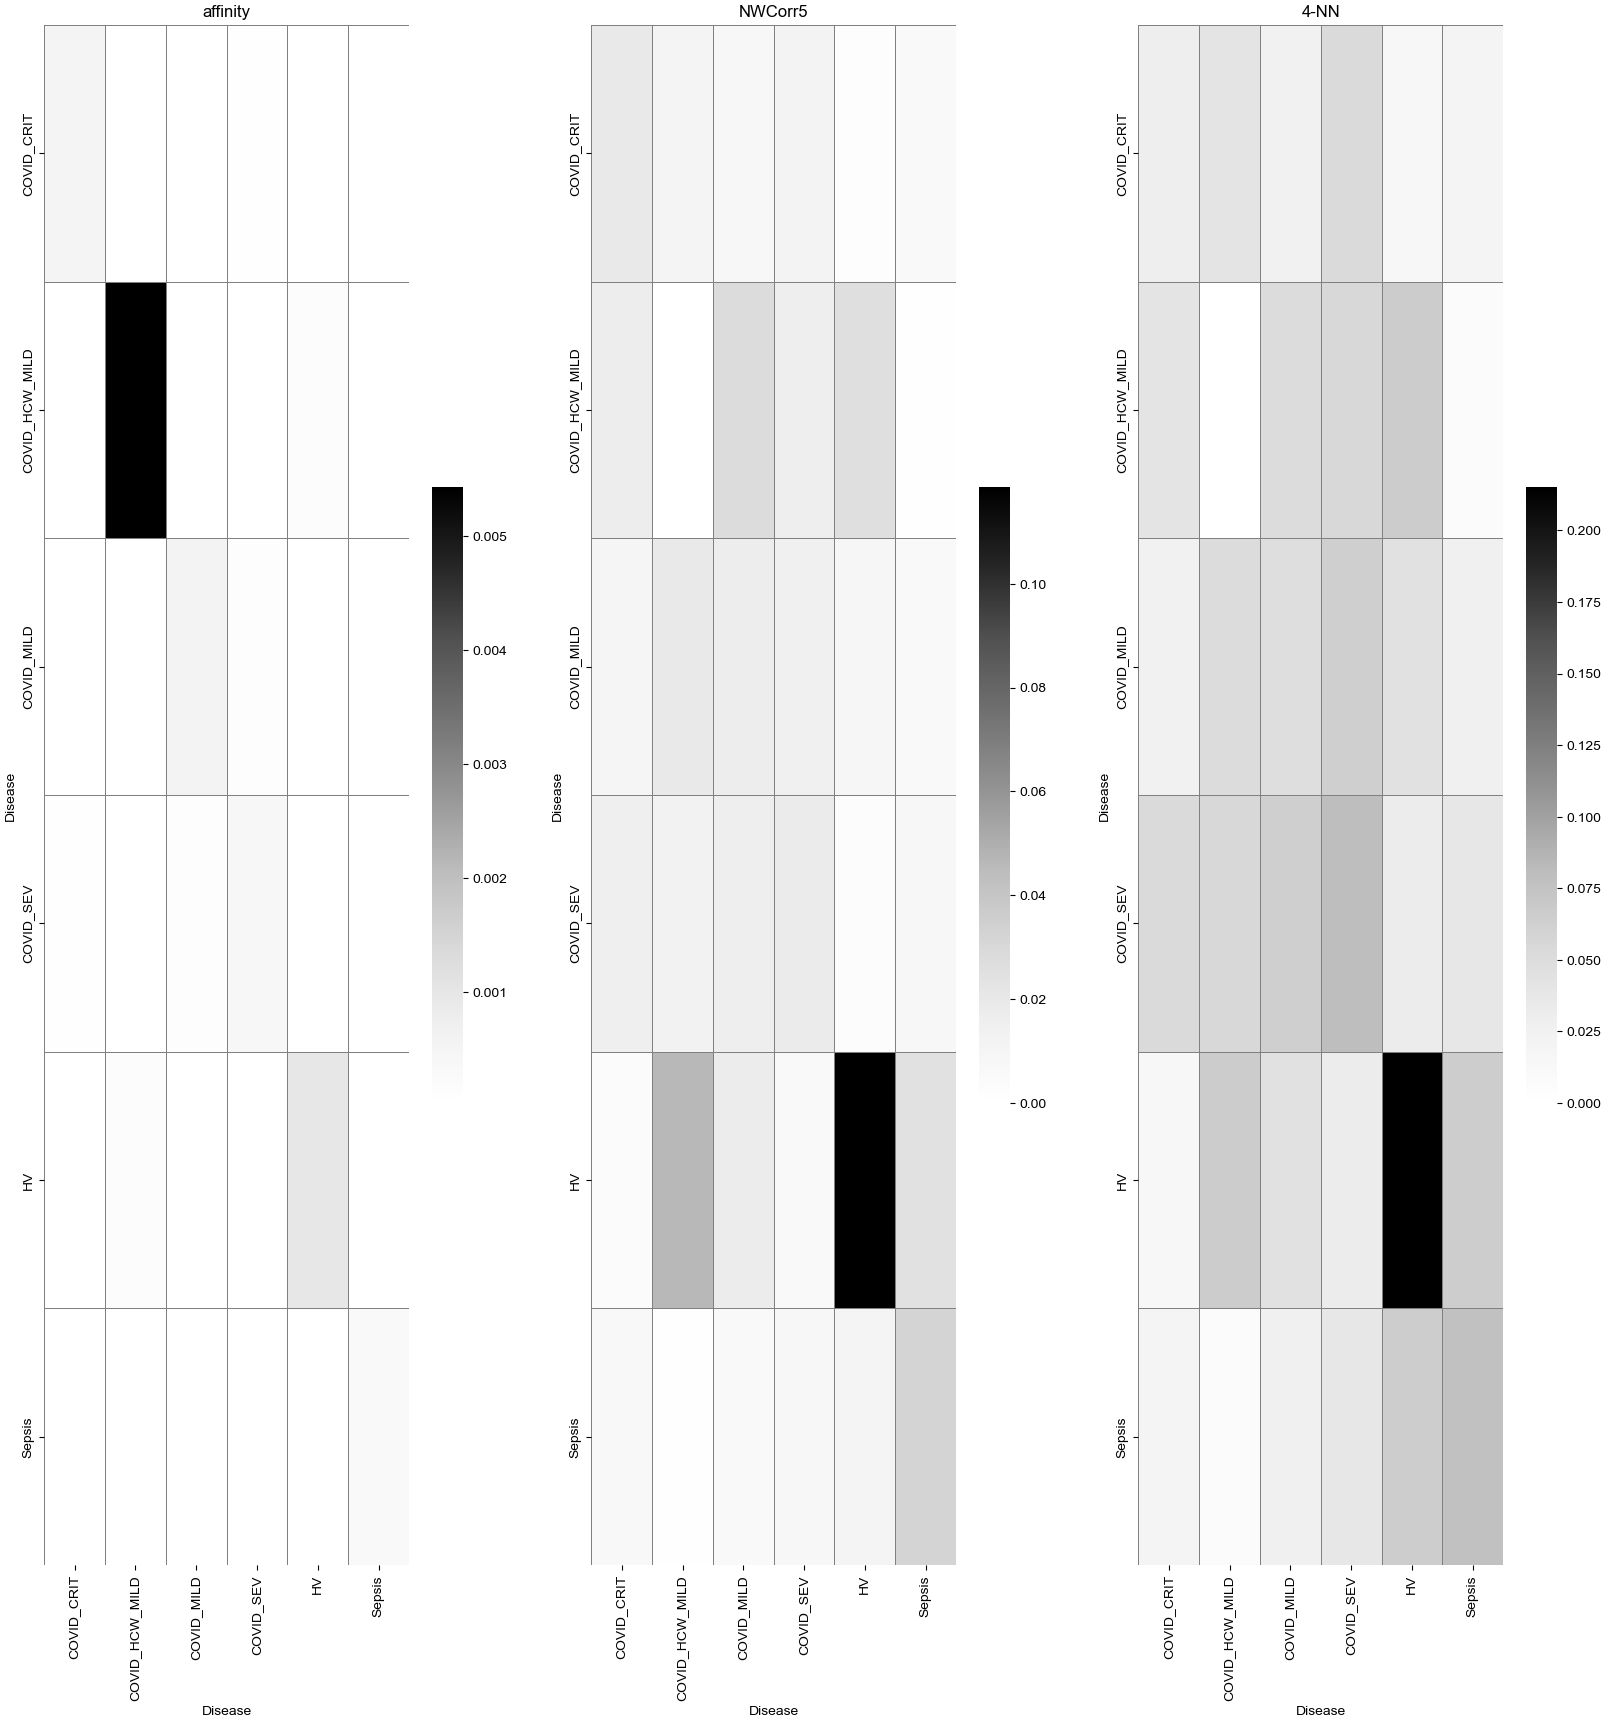

In [163]:
knn_df_sum_grouped = knn_df_sum.groupby(by = ['Disease']).mean().T.groupby(by = ['Disease']).mean()
aff_df_sum_grouped = aff_df_sum.groupby(by = ['Disease']).mean().T.groupby(by = ['Disease']).mean()
corr_df_sum_grouped = corr_df_sum.groupby(by = ['Disease']).mean().T.groupby(by = ['Disease']).mean()

fig, ax = plt.subplots(1, 3, figsize=(20,20))

sb.heatmap(aff_df_sum_grouped, cmap = "Greys", robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.4}, ax = ax[0])
ax[0].set_title("affinity")
sb.heatmap(corr_df_sum_grouped, cmap = "Greys", robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.4}, ax = ax[1])
ax[1].set_title("NWCorr5")
sb.heatmap(knn_df_sum_grouped, cmap = "Greys", robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.4}, ax = ax[2])
ax[2].set_title("4-NN")

# Graph Fusion

## Normalized-PSN-Concat

<Axes: >

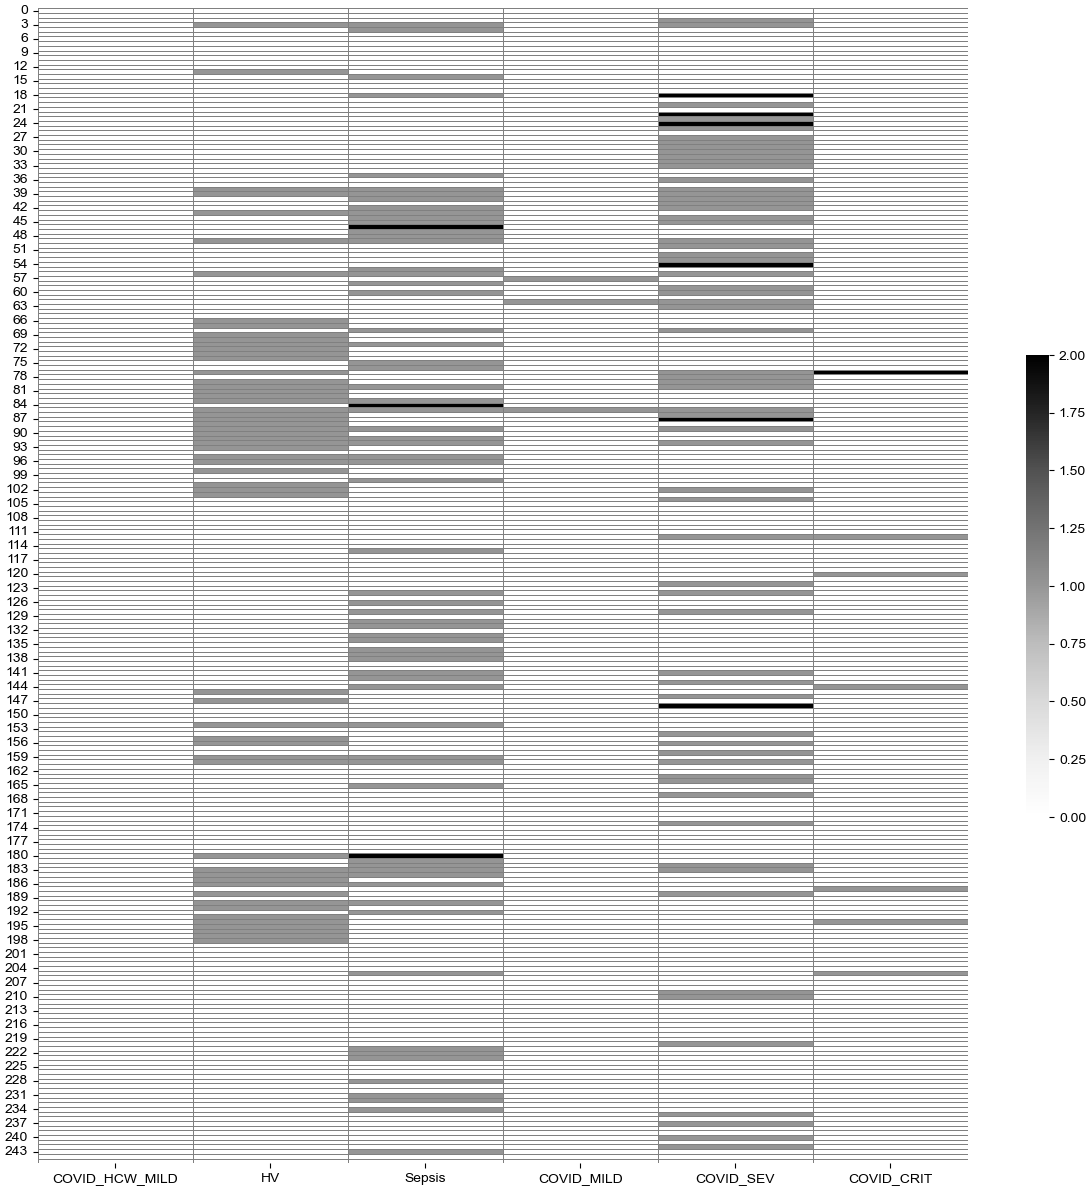

In [180]:
index = diseases
per_graph_disease_freq = {}
for i, clusters in per_cluster_disease_assignment.items():
    d = {d: 0 for d in diseases } 
    for c, assignment in clusters.items():
        if not assignment == "none":
            d[assignment]+=1
    per_graph_disease_freq[i] = list(d.values())
df = pd.DataFrame(data = per_graph_disease_freq, index = index).transpose()

fig, ax = plt.subplots(figsize=(15,15))
sb.heatmap(df, cmap = "Greys", robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.4}, ax = ax)


In [181]:
per_cluster_disease_group_assignment = {}
per_cluster_pure_disease_group_assignment = {}
for i, clusters in per_cluster_disese_groups_distr.items():
    per_cluster_disease_group_assignment[i] = {}
    per_cluster_pure_disease_group_assignment[i] = {}
    for c, dg_distr in clusters.items():
        num_patients_in_c = num_patients_in_clusters[i][c]
        assignment = [d for d, v in dg_distr.items() if round(v/num_patients_in_c, 2)>= 0.7]
        assignment_pure = [d for d, v in dg_distr.items() if round(v/num_patients_in_c, 2)>= 1]
        if len(assignment) == 0:
            per_cluster_disease_group_assignment[i][c] = "none"
        else:
            per_cluster_disease_group_assignment[i][c] = assignment[0]
        if len(assignment_pure) == 0:
            per_cluster_pure_disease_group_assignment[i][c] = "none"
        else:
            per_cluster_pure_disease_group_assignment[i][c] = assignment_pure[0]

<Axes: >

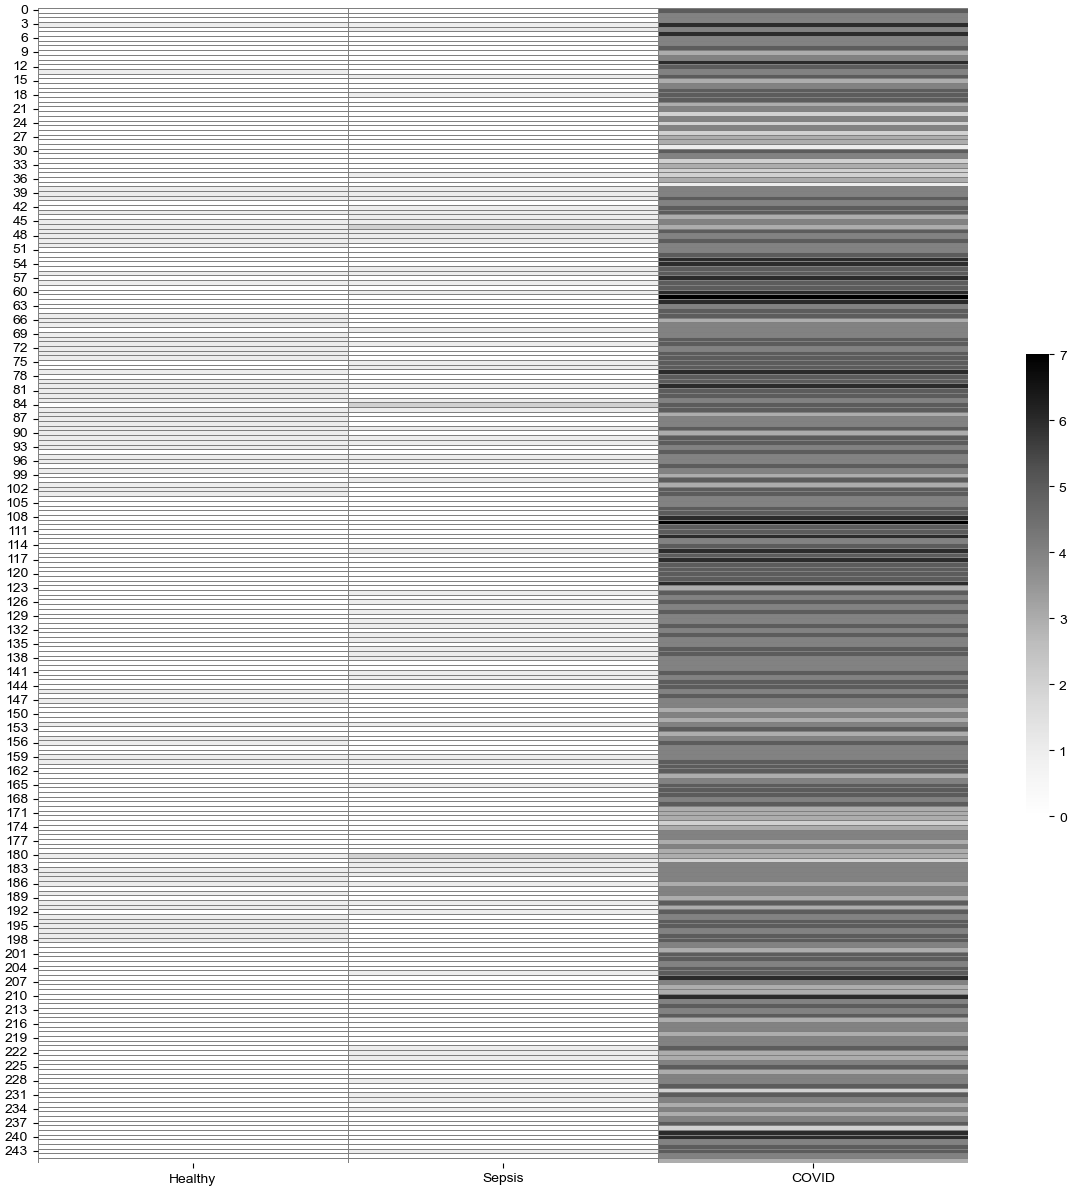

In [182]:
index = disease_groups
per_graph_disease_group_freq = {}
for i, clusters in per_cluster_disease_group_assignment.items():
    dg = {dg: 0 for dg in disease_groups } 
    for c, assignment in clusters.items():
        if not assignment == "none":
            dg[assignment]+=1
    per_graph_disease_group_freq[i] = list(dg.values())

df = pd.DataFrame(data = per_graph_disease_group_freq, index = index).transpose()
fig, ax = plt.subplots(figsize=(15,15))
sb.heatmap(df, cmap = "Greys", robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.4}, ax = ax)


<Axes: >

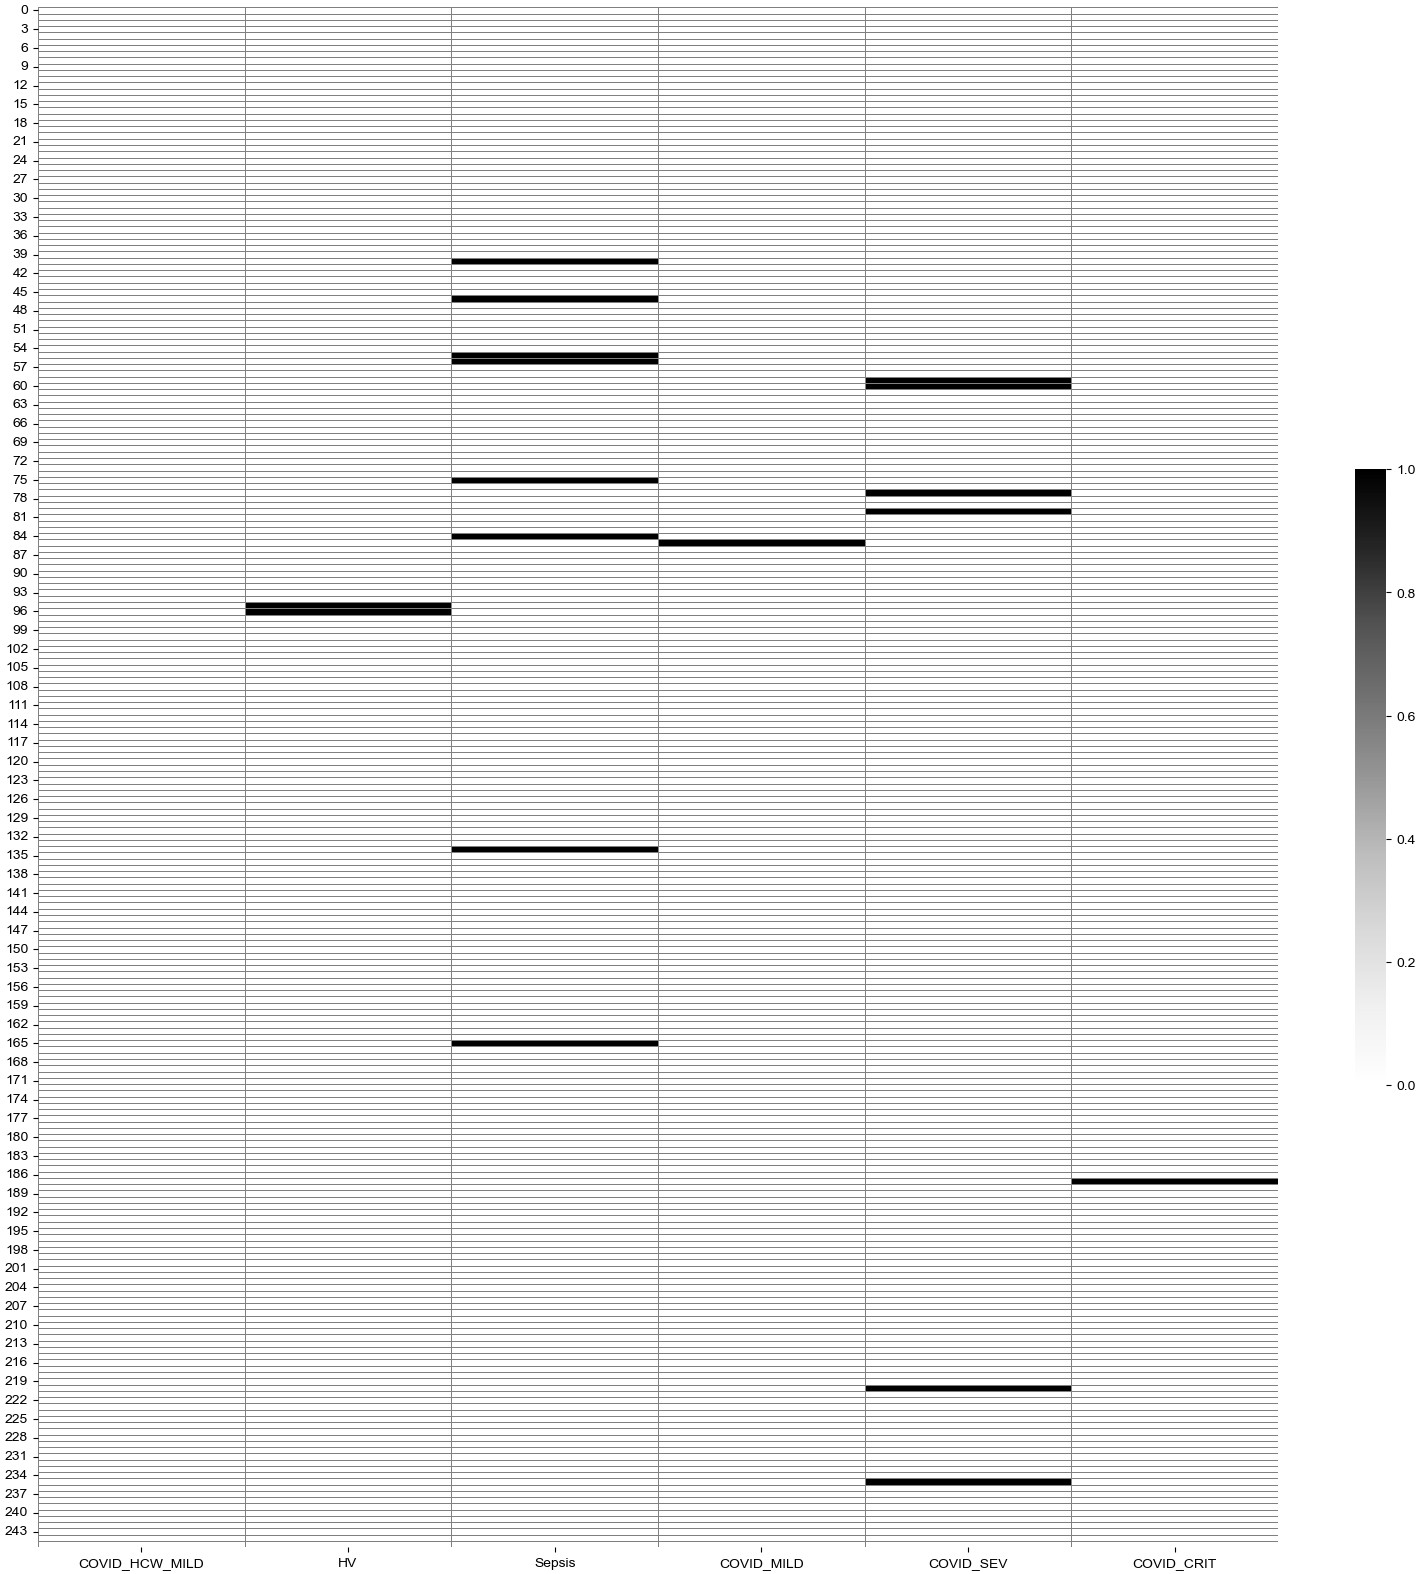

In [184]:
index = diseases
per_graph_pure_disease_group_freq = {}
for i, clusters in per_cluster_pure_disease_assignment.items():
    dg = {dg: 0 for dg in diseases } 
    for c, assignment in clusters.items():
        if not assignment == "none":
            dg[assignment]+=1
    per_graph_pure_disease_group_freq[i] = list(dg.values())

fig, ax = plt.subplots(figsize=(20,20))
df = pd.DataFrame(data = per_graph_pure_disease_group_freq, index = index).transpose()
sb.heatmap(df, cmap = "Greys", robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.4}, ax = ax)

<Axes: >

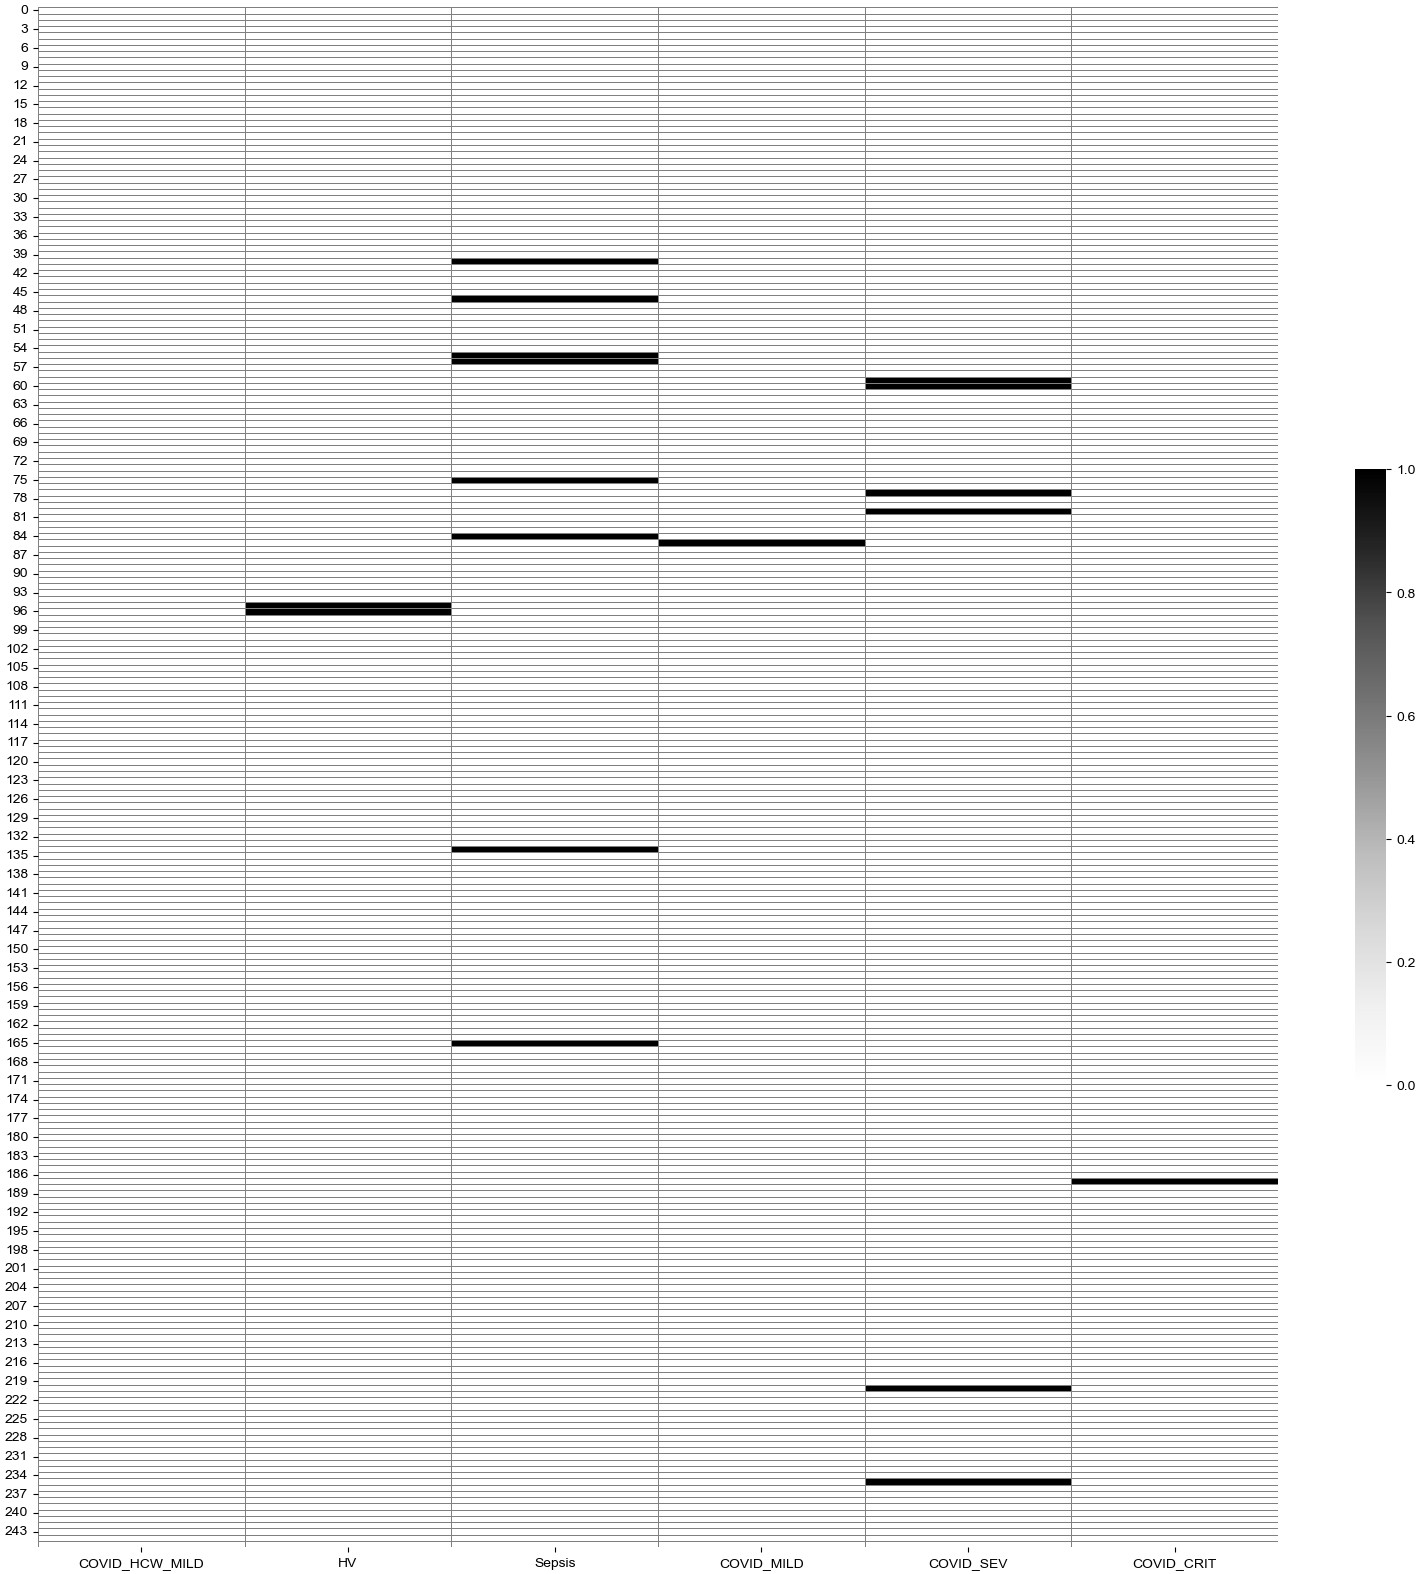

In [185]:
index = diseases
per_graph_pure_diseases_freq = {}
for i, clusters in per_cluster_pure_disease_assignment.items():
    d = {d: 0 for d in diseases } 
    for c, assignment in clusters.items():
        if not assignment == "none":
            d[assignment]+=1
    per_graph_pure_diseases_freq[i] = list(d.values())

fig, ax = plt.subplots(figsize=(20,20))
df = pd.DataFrame(data = per_graph_pure_diseases_freq, index = index).transpose()
sb.heatmap(df, cmap = "Greys", robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.4}, ax = ax)

<Axes: >

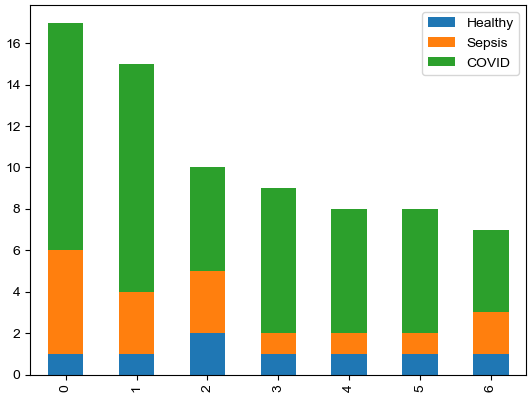

In [189]:
g = graphs_with_74_nodes[125]
number_of_clusters = len(g.obs.leiden.unique())
diseases = list(g.obs.Disease.unique())
disease_groups = list(g.obs.DiseaseGroup.unique())
cluster_membership_diseses = {str(c): {d: 0 for d in diseases } for c in range(number_of_clusters)}
cluster_membership_disese_groups = {str(c): {dg: 0 for dg in disease_groups } for c in range(number_of_clusters)}

for p in  g.obs_names:
    d = g[p].obs.Disease[0]
    dg = g[p].obs.DiseaseGroup[0]
    c = g[p].obs.leiden[0]

    cluster_membership_diseses[c][d] += 1
    cluster_membership_disese_groups[c][dg] += 1

df = pd.DataFrame().from_dict(cluster_membership_disese_groups)
df.transpose().plot(kind='bar', stacked=True, legend = True )

<Axes: >

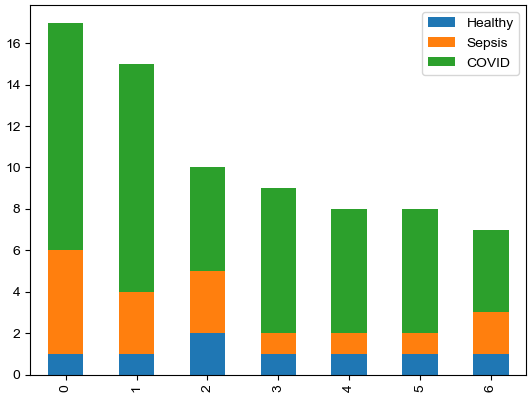

In [190]:
g = graphs_with_74_nodes[125]
number_of_clusters = len(g.obs.leiden.unique())
diseases = list(g.obs.Disease.unique())
disease_groups = list(g.obs.DiseaseGroup.unique())
cluster_membership_diseses = {str(c): {d: 0 for d in diseases } for c in range(number_of_clusters)}
cluster_membership_disese_groups = {str(c): {dg: 0 for dg in disease_groups } for c in range(number_of_clusters)}

for p in  g.obs_names:
    d = g[p].obs.Disease[0]
    dg = g[p].obs.DiseaseGroup[0]
    c = g[p].obs.leiden[0]

    cluster_membership_diseses[c][d] += 1
    cluster_membership_disese_groups[c][dg] += 1

df = pd.DataFrame().from_dict(cluster_membership_disese_groups)
df.transpose().plot(kind='bar', stacked=True, legend = True )

## Graph Analysis Concatenation

In [107]:
num_V = len(shared_patients_across_networks_74)
e = [(v1,v2) for v1 in range(num_V) for v2 in range(v1)]
fully = ig.Graph(num_V, e, directed = False)

In [188]:
df = graphs_with_74_nodes[0].to_df().T.corr()
corr = df
corr = np.triu(corr) # Avoiding duplicates, since the matrix is symmetric
corr = corr[corr>0] # Discard negative correlation 
corr = corr[corr<1] # Discard correlation with self
percentile = np.percentile(corr, 95) 
e = [(i,j) for i in range(num_V) for j in range(i) if df.iloc[i,j] >= percentile]
corr95 = ig.Graph(num_V, e, directed = False)

percentile = np.percentile(corr, 90) 
e = [(i,j) for i in range(num_V) for j in range(i) if df.iloc[i,j] >= percentile]
corr90 = ig.Graph(num_V, e, directed = False)

percentile = np.percentile(corr, 97) 
e = [(i,j) for i in range(num_V) for j in range(i) if df.iloc[i,j] >= percentile]
corr97 = ig.Graph(num_V, e, directed = False)


percentile = np.percentile(corr, 99) 
e = [(i,j) for i in range(num_V) for j in range(i) if df.iloc[i,j] >= percentile]
corr99 = ig.Graph(num_V, e, directed = False)

In [191]:
# Do leiden clustering on above 
corr90_ad = ad.AnnData(np.array(list(corr90.get_adjacency())))
corr95_ad = ad.AnnData(np.array(list(corr95.get_adjacency())))
corr97_ad = ad.AnnData(np.array(list(corr97.get_adjacency())))
corr99_ad = ad.AnnData(np.array(list(corr99.get_adjacency())))


scp.pp.neighbors(corr90_ad, n_neighbors = 4, use_rep='X')
scp.tl.leiden(corr90_ad, resolution=1 )

scp.pp.neighbors(corr95_ad, n_neighbors = 4, use_rep='X')
scp.tl.leiden(corr95_ad, resolution=1 )

scp.pp.neighbors(corr97_ad, n_neighbors = 4, use_rep='X')
scp.tl.leiden(corr97_ad, resolution=1 )

scp.pp.neighbors(corr99_ad, n_neighbors = 4, use_rep='X')
scp.tl.leiden(corr99_ad, resolution=1 )

/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_61645/676522023.py:2: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  corr90_ad = ad.AnnData(np.array(list(corr90.get_adjacency())))
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_61645/676522023.py:3: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  corr95_ad = ad.AnnData(np.array(list(corr95.get_adjacency())))
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_61645/676522023.py:4: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automati

In [197]:
corr99_ad.obs.leiden.unique()

['0', '2', '3', '4', '1']
Categories (5, object): ['0', '1', '2', '3', '4']

In [196]:
corr97_ad.obs.leiden.unique()

['0', '2', '3', '5', '4', '1']
Categories (6, object): ['0', '1', '2', '3', '4', '5']

In [195]:
corr95_ad.obs.leiden.unique()

['0', '2', '1', '4', '5', '3']
Categories (6, object): ['0', '1', '2', '3', '4', '5']

In [194]:
corr90_ad.obs.leiden.unique()

['0', '3', '5', '6', '7', '1', '4', '2']
Categories (8, object): ['0', '1', '2', '3', '4', '5', '6', '7']

In [173]:
number_of_clusters = len(averaged_graph.obs.leiden.unique())
diseases = list(averaged_graph.obs.Disease.unique())
disease_groups = list(averaged_graph.obs.DiseaseGroup.unique())
cluster_membership_diseses = {str(c): {d: 0 for d in diseases } for c in range(number_of_clusters)}
cluster_membership_disese_groups = {str(c): {dg: 0 for dg in disease_groups } for c in range(number_of_clusters)}

#
for p in  averaged_graph.obs_names:
    d = averaged_graph[p].obs.Disease[0]
    dg = averaged_graph[p].obs.DiseaseGroup[0]
    c = averaged_graph[p].obs.leiden[0]
    if c == "2" and dg == "Sepsis":
        print(p)

    cluster_membership_diseses[c][d] += 1
    cluster_membership_disese_groups[c][dg] += 1

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

In [140]:
e = []
weights = []
df = np.array(graphs_with_74_nodes[0].to_df().T.corr())

for i, row in enumerate(df):
    non_one_row = row[row<1] # remove self correlation
    percentile = np.percentile(non_one_row, 95) 
    for j, column in enumerate(row):
        if column < 1 and column > 0:
            if column >= percentile:
                e.append((i,j))

NWcorr50 = ig.Graph(num_V, e, directed = False)

In [161]:
nn = ig.Graph.Adjacency(sparse.csr_matrix.todense(graphs_with_74_nodes[0].obsp["distances"]), directed=False)